In [1]:
from utils import get_global_config, get_waveform_path, get_base_time, get_ending_time, plot_waveform

from pyspark.sql.functions import datediff, to_date, max as max_, lit, col, collect_list, row_number, concat_ws, format_number, concat, monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.pandas.frame import DataFrame
import pyspark.pandas as ps
from pyspark.sql.functions import to_timestamp

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wfdb


/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
spark = SparkSession.builder.appName('Read CSV File into DataFrame').\
            config("spark.executor.cores","8").\
            config("spark.driver.cores","2").\
            config("spark.driver.memory","2g").\
            config("spark.executor.memory","4g").\
            config("spark.sql.shuffle.partitions","4").\
            config("spark.sql.execution.arrow.pyspark.enabled", "true").\
            config("spark.sql.files.maxPartitionBytes", "128m").\
            getOrCreate()

sc = spark.sparkContext

cfg = get_global_config()

23/04/08 14:25:54 WARN Utils: Your hostname, Michaels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.118 instead (on interface en0)
23/04/08 14:25:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/08 14:25:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [74]:
cfg['OUTPUTPATH']
cfg['EXPLOREPATH']='//Users/michaelscott/bd4h/project/streaming-env/time-series-kafka-demo/explore_output'

In [3]:
# DATAPATH = '../data' 
# MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
# DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
# WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
# CHANNEL_NAMES = ['HR','RESP','PULSE','etco2', 'SpO2', 'CVP','AWRR', 'NBP Mean',  'NBP Dias', 'NBP Sys']
# # CARD_ICD_9 =["4275", "4271", "42741", "42742", "99.60", "99.63", "99.62", "38.97", "96.04", "39.66", "39.95", "41.92", "96.70", "96.71", "96.72"]
# EXPLOREPATH = './output'

In [48]:
# def get_waveform_path(record_id):
#     patient_id = f'{record_id[0:7]}'
#     return cfg['WAVEFPATH'] + f'/{patient_id[0:3]}/{patient_id}/{record_id}'

# def patientid_to_path(patientid):
#     "Convert 20 to p00/p000020/"
#     return f'p{patientid:06d}'

# def plot_waveform(record_name = 'p087675-2104-12-05-03-53n', ca_time_str = '2104-12-05 08:40:00'):
#     # Get waveform data
#     patient_path = get_waveform_path(record_name)
#     record = wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

#     # Select only HR from the plots, not with the channels parameter
#     fig = wfdb.plot_wfdb(record=record, title=record_name[0:7], figsize=(10,15), return_fig=True)
#     ax_list = fig.axes

#     # get time when recording started
#     base_time = datetime.datetime.combine(record.__dict__['base_date'], 
#                             record.__dict__['base_time'])

#     # Create datetime using strptime
#     ca_time = datetime.datetime.strptime(ca_time_str, '%Y-%m-%d %H:%M:%S')

#     # find time delta between base_time and ca_time
#     # Convert it to an int that represents the number of seconds
#     time_delta = int((ca_time - base_time).total_seconds())

#     # Plot a vertical line at time_delta
#     if time_delta > 0:
#         for ax in ax_list:
#             ax.axvline(x=time_delta, color='red', linestyle='--',)
#     else:
#         # change title of fig
#         fig.suptitle('Cardiac Arrest Time is before the start of the recording')

#     fig.show()

#     display(record.__dict__)

# def get_base_time(record_name='p087675-2104-12-05-03-53n'):
#     basetime = record_name[8:]
#     basetime = basetime.strip().strip('n')
#     return basetime

# def get_ending_time(record_name = 'p087675-2104-12-05-03-53n'):
#     # Get waveform data
#     patient_path = get_waveform_path(record_name)
#     record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
    
#     # get time when recording started
#     base_time = datetime.datetime.combine(record.__dict__['base_date'], 
#                             record.__dict__['base_time'])
    
#     duration = record.__dict__['sig_len'] * (1/record.__dict__['fs']) 

#     # Add duration to base time
#     end_time = base_time + datetime.timedelta(seconds=duration)

#     record_present = [0 for i in range(len(CHANNEL_NAMES))]

#     # One hot encode the presence of signals
#     for idx, val in enumerate(CHANNEL_NAMES):
#         if val in record.__dict__['sig_name']:
#             record_present[idx] = 1

#     return end_time, record_present

In [21]:
# # Data cleaning and preprocessing 
# # Creating the dataframe for noteevents
# # NOTEEVENTS do not have datetime, so it is our job to find the datetime from the NOTEEVENTS 
# # Here's the hoping that this is not 
# NOTEEVENTS_ORIG = pd.read_csv(f'{MIMICPATH}/NOTEEVENTS_ORIG.csv.gz',usecols=['ROW_ID','CHARTTIME'], parse_dates=['CHARTTIME'])

# # drop rows with null from NOTEEVENTS_ORIG
# NOTEEVENTS_ORIG = NOTEEVENTS_ORIG.dropna()

# # Export to path
# # NOTEEVENTS_ORIG.to_csv(f'{MIMICPATH}/NOTEEVENTS_TIME.csv.gz', index=False, compression='gzip')

KeyboardInterrupt: 

In [4]:
def read_into_pyspark(file, schema=None, cache=False):
    if not schema:
        df=spark.read.csv(f'file:/{cfg["MIMICPATH"]}/{file}.csv.gz', header=True, inferSchema=True)
    else:
        df=spark.read.csv(f'file:/{cfg["MIMICPATH"]}/{file}.csv.gz', header=True, schema=schema)
    if cache:
        df.cache()
    df.createOrReplaceTempView(file)
    return df

In [67]:
chartevents_schema = StructType([
    StructField('ROW_ID', IntegerType(), True),
    StructField('SUBJECT_ID', IntegerType(), True),
    StructField('HADM_ID', IntegerType(), True),
    StructField('ICUSTAY_ID', IntegerType(), True),
    StructField('ITEMID', IntegerType(), True),
    StructField('CHARTTIME', TimestampType(), True),
    StructField('STORETIME', TimestampType(), True),
    StructField('CGID', IntegerType(), True),
    StructField('VALUE', StringType(), True),
    StructField('VALUENUM', FloatType(), True),
    StructField('VALUEUOM', StringType(), True),
    StructField('WARNING', IntegerType(), True),
    StructField('ERROR', IntegerType(), True),
    StructField('RESULTSTATUS', StringType(), True),
    StructField('STOPPED', StringType(), True)
])


d_icd_procedures_schema = StructType([
    StructField('ROW_ID', IntegerType(), True),
    StructField('ICD9_CODE', StringType(), True),
    StructField('SHORT_TITLE', StringType(), True),
    StructField('LONG_TITLE', StringType(), True)
])


# Create schema for DATETIMEEVENTS 
datetimeevents_schema = StructType([
    StructField("ROW_ID", IntegerType(), True),
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("HADM_ID", IntegerType(), True),
    StructField("ICUSTAY_ID", IntegerType(), True),
    StructField("ITEMID", IntegerType(), True),
    StructField("CHARTTIME", TimestampType(), True),
    StructField("STORETIME", TimestampType(), True),
    StructField("CGID", IntegerType(), True),
    StructField("VALUE", StringType(), True),
    StructField("VALUEUOM", StringType(), True),
    StructField("WARNING", IntegerType(), True),
    StructField("ERROR", IntegerType(), True),
    StructField("RESULTSTATUS", StringType(), True),
    StructField("STOPPED", StringType(), True)
])

noteevents_schema = StructType([
    StructField("ROW_ID", IntegerType(), True),
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("HADM_ID", IntegerType(), True),
    StructField("CHARTDATE", TimestampType(), True),
    # StructField("CHARTTIME", TimestampType(), True),
    # StructField("STORETIME", TimestampType(), True),
    StructField("CATEGORY", StringType(), True),
    StructField("DESCRIPTION", StringType(), True),
    StructField("CGID", IntegerType(), True),
    StructField("ISERROR", StringType(), True),
    StructField("TEXT", StringType(), True)
])

# create schema for noteevents_time
noteevents_time_schema = StructType([
    StructField("ROW_ID", IntegerType(), True),
    StructField("CHARTTIME", TimestampType(), True)
])

# create schema for PATIENTS_BASETIME
patientsbasetime_schema = StructType([
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("BASETIME", StringType(), True),
    StructField("RECORDNAME", StringType(), True)

])

patientsendtime_schema = StructType([
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("RECORDNAME", StringType(), True),
    StructField("FINISHTIME", StringType(), True),
    StructField("HR", IntegerType(), True),
    StructField("RESP", IntegerType(), True),
    StructField("PULSE", IntegerType(), True),
    StructField("etco2", IntegerType(), True),
    StructField("SpO2", IntegerType(), True),
    StructField("CVP", IntegerType(), True),
    StructField("AWRR", IntegerType(), True),
    StructField("NBP_MEAN", IntegerType(), True),
    StructField("NBP_DIAS", IntegerType(), True),
    StructField("NBp_SYS", IntegerType(), True)
                ])

# Create schema for datetimeevents
datetimeevents_schema = StructType([
    StructField("ROW_ID", IntegerType(), True),
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("HADM_ID", IntegerType(), True),
    StructField("ICUSTAY_ID", IntegerType(), True),
    StructField("ITEMID", IntegerType(), True),
    StructField("CHARTTIME", TimestampType(), True),
    StructField("STORETIME", TimestampType(), True),
    StructField("CGID", IntegerType(), True),
    StructField("VALUE", StringType(), True),
    StructField("VALUEUOM", StringType(), True),
    StructField("WARNING", IntegerType(), True),
    StructField("ERROR", IntegerType(), True),
    StructField("RESULTSTATUS", StringType(), True),
    StructField("STOPPED", StringType(), True)
])


# create schema for all remaining tables in alphebetical order in one go


In [6]:
ADMISSIONS = read_into_pyspark('ADMISSIONS')
# CALLOUT = read_into_pyspark('CALLOUT')
CHARTEVENTS = read_into_pyspark('CHARTEVENTS', schema=chartevents_schema)
CPTEVENTS = read_into_pyspark('CPTEVENTS')
DIAGNOSES_ICD = read_into_pyspark('DIAGNOSES_ICD')
DATETIMEEVENTS = read_into_pyspark('DATETIMEEVENTS',datetimeevents_schema)
D_ICD_DIAGNOSES = read_into_pyspark('D_ICD_DIAGNOSES', schema=d_icd_procedures_schema)
D_ICD_PROCEDURES = read_into_pyspark('D_ICD_PROCEDURES', schema=d_icd_procedures_schema)
D_ITEMS = read_into_pyspark('D_ITEMS')
# ICUSTAYS = read_into_pyspark('ICUSTAYS')
# INPUTEVENTS_CV = read_into_pyspark('INPUTEVENTS_CV')
# INPUTEVENTS_MV = read_into_pyspark('INPUTEVENTS_MV')
# LABEVENTS = read_into_pyspark('LABEVENTS')
NOTEEVENTS = read_into_pyspark('NOTEEVENTS', schema=noteevents_schema) #this is a modified version of noteevents that is cleaned
NOTEEVENTS_TIME = read_into_pyspark('NOTEEVENTS_TIME', schema=noteevents_time_schema) #this is a modified version of noteevents that is cleaned
# OUTPUTEVENTS = read_into_pyspark('OUTPUTEVENTS')
PATIENTS = read_into_pyspark('PATIENTS')
# PRESCRIPTIONS = read_into_pyspark('PRESCRIPTIONS')
PROCEDUREEVENTS_MV = read_into_pyspark('PROCEDUREEVENTS_MV')
PROCEDURES_ICD = read_into_pyspark('PROCEDURES_ICD')
# SERVICES = read_into_pyspark('SERVICES')
# TRANSFERS = read_into_pyspark('TRANSFERS')


In [ ]:
# diag_df = ps.read_csv(f'{MIMICPATH}/DIAGNOSES_ICD.csv.gz',compression='gzip')
# admissions_df = ps.read_csv(f'{cfg["MIMICPATH"]}/ADMISSIONS.csv.gz', compression='gzip')
# icu_df = ps.read_csv(f'{cfg["MIMICPATH"]}/ICUSTAYS.csv.gz', compression='gzip')
# patients_df = ps.read_csv(f'{MIMICPATH}/PATIENTS.csv.gz', compression='gzip')
# procedures_df = ps.read_csv(f'{MIMICPATH}/PROCEDURES_ICD.csv.gz', compression='gzip')
# procedures_mv_df = ps.read_csv(f'{MIMICPATH}/PROCEDUREEVENTS_MV.csv.gz', compression='gzip')
# d_items_df = ps.read_csv(f'{MIMICPATH}/D_ITEMS.csv.gz', compression='gzip')

# diag_df = spark.read.csv(f'{MIMICPATH}/DIAGNOSES_ICD.csv.gz', header=True, inferSchema=True)
# admissions_df = spark.read.csv(f'{MIMICPATH}/ADMISSIONS.csv.gz', header=True, inferSchema=True)
# icu_df = spark.read.csv(f'{MIMICPATH}/ICUSTAYS.csv.gz', header=True, inferSchema=True)
# patients_df = spark.read.csv(f'{MIMICPATH}/PATIENTS.csv.gz', header=True, inferSchema=True)
# procedures_df = spark.read.csv(f'{MIMICPATH}/PROCEDURES_ICD.csv.gz', header=True, inferSchema=True)
# procedures_mv_df = spark.read.csv(f'{MIMICPATH}/PROCEDUREEVENTS_MV.csv.gz', header=True, inferSchema=True)
# d_items_df = spark.read.csv(f'{MIMICPATH}/D_ITEMS.csv.gz', header=True, inferSchema=True)
# d_icd_diagnoses = spark.read.csv(f'{MIMICPATH}/D_ICD_DIAGNOSES.csv.gz', header=True, inferSchema=True)


In [7]:
# Find matched patients
# The file "/Users/michaelscott/bd4h/project/data/waveform/physionet.org/files/mimic3wdb-matched/1.0/RECORDS"
# contains a list of all the records in the waveform database.
# Each line is "p00/p000085/"
# Now, extract all the patient IDs that are present in this file
# and that will be used to filter all the other tables.

from pyspark.sql.functions import substring

# Read the RECORDS file as a text file and split each line into patient IDs
# convert string to int
patient_ids = spark.read.text(f"file://{cfg['WAVEFPATH']}/RECORDS") \
                    .select(substring("value", 6, 6).alias("SUBJECT_ID")) \
                    .selectExpr("CAST(SUBJECT_ID AS INT) AS SUBJECT_ID")\
                    .distinct()

patient_ids.createOrReplaceTempView('matched_patients')
# Show the first 10 patient IDs in the DataFrame
patient_ids.show(10)

# Use the patient IDs to filter another PySpark table
# other_table_filtered = other_table.join(patient_ids, on="patient_id", how="inner")

# Get all patient_id from matched_patients as a list
patientid = patient_ids.select('SUBJECT_ID').rdd.flatMap(lambda x: x).collect()

+----------+
|SUBJECT_ID|
+----------+
|        52|
|       107|
|       109|
|       135|
|       177|
|       263|
|       292|
|       308|
|       317|
|       328|
+----------+
only showing top 10 rows



In [123]:
# # Download the RECORDS file of all patients in matched dataset
# def patientid_to_path(patientid):
#     # "Convert 20 to p00/p000020/"
#     return f'p{patientid:06d}'

# cmd = f"cd .. "
# idx=50
# # Download all the patient records in parallel
# while idx <= len(patientid) -1:
#     patient = patientid_to_path(patientid[idx])
#     cmd += f"&& /Users/michaelscott/opt/anaconda3/bin/wget -r -N -c -q -np https://physionet.org/files/mimic3wdb-matched/1.0/{patient[0:3]}/{patient}/RECORDS -P data/waveform"
#     idx+=1
#     if idx%50==0:
#         # os.system(cmd)
#         process = subprocess.Popen(cmd, shell=True)
#         cmd = f"cd .. "


In [53]:
# "/Users/michaelscott/bd4h/project/data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p00/p009332/RECORDS"
# For each RECORDS file, open each file. Each file should start off with a few lines that has the following format:
# p000000-YYYY-MM-DD-HH-MM or p000000-YYYY-MM-DD-HH-MMn where n is a literal n
# Then, retrieve each line. Save "p000000" and "YYYY-MM-DD-HH-MM" as a row in a pyspark table
# where patient_id is the first 7 letters of each string (p000000), and basedate is the "YYYY-MM-DD-HH-MM"

record_files = glob.glob(F'{cfg["WAVEFPATH"]}/**/**/RECORDS')

# Initialize an empty list to store the rows
patientsbasetime_rows = set()

# Iterate over each RECORDS file
for file in record_files:
    # Read each file
    with open(file, 'r') as f:
        lines = f.readlines()
        
    # Find records with the desired format and extract patient_id and basedate
    for line in lines:
        if line.startswith('p') and '-' in line and 'n' in line:
            # Retrieve only the numeric data
            patient_id = int(line[1:7])
            basetime = get_base_time(line)

            # Add the row to the list
            patientsbasetime_rows.add((patient_id, basetime, line.strip('\n')))

patientsbasetime_rows = list(patientsbasetime_rows)

# Convert the list of rows to a PySpark DataFrame
PATIENT_BASETIME = spark.createDataFrame(patientsbasetime_rows, patientsbasetime_schema)
PATIENT_BASETIME = PATIENT_BASETIME.withColumn("BASETIME", to_timestamp(PATIENT_BASETIME['BASETIME'], 'yyyy-MM-dd-HH-mm'))

# Show the DataFrame
PATIENT_BASETIME.show()

PATIENT_BASETIME.createOrReplaceTempView('PATIENT_BASETIME')

PATIENT_BASETIME.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/PATIENT_BASETIME', header=True, mode='overwrite')


+----------+-------------------+--------------------+
|SUBJECT_ID|           BASETIME|          RECORDNAME|
+----------+-------------------+--------------------+
|     17735|2173-01-13 06:05:00|p017735-2173-01-1...|
|     32796|2133-01-29 18:46:00|p032796-2133-01-2...|
|     19726|2141-09-18 13:32:00|p019726-2141-09-1...|
|     78979|2169-11-08 13:42:00|p078979-2169-11-0...|
|     53036|2154-01-23 09:30:00|p053036-2154-01-2...|
|     97237|2132-08-07 11:06:00|p097237-2132-08-0...|
|     44023|2157-09-20 17:55:00|p044023-2157-09-2...|
|     22577|2120-01-22 13:33:00|p022577-2120-01-2...|
|     67301|2193-04-13 15:26:00|p067301-2193-04-1...|
|     83537|2185-12-02 11:25:00|p083537-2185-12-0...|
|     71582|2100-07-20 11:21:00|p071582-2100-07-2...|
|     32805|2182-12-13 10:11:00|p032805-2182-12-1...|
|     99783|2125-11-06 10:35:00|p099783-2125-11-0...|
|     25116|2195-12-25 02:50:00|p025116-2195-12-2...|
|      7585|2110-07-16 21:34:00|p007585-2110-07-1...|
|     49925|2152-08-23 18:25

# Use Notes to Obtain Cardiac Arrest Patients
We have obtained TWO very obvious cases of cardiac arrest. Can we get more from non-obvious cases by reading the notes?

In [223]:
# Creating only matched patients
noteevents_matched = spark.sql(""" 
SELECT noteevents.* 
FROM noteevents 
INNER JOIN matched_patients
ON noteevents.SUBJECT_ID = matched_patients.SUBJECT_ID""")
noteevents_matched.createOrReplaceTempView('noteevents_matched')
noteevents_matched.cache()

# convert description to lower case and match against cardiac arrest
noteevents_matched_cardiacarrest = spark.sql("""
SELECT noteevents_matched.*, noteevents_time.CHARTTIME
FROM noteevents_matched
LEFT JOIN noteevents_time
ON noteevents_matched.ROW_ID = noteevents_time.ROW_ID
WHERE lower(DESCRIPTION) LIKE '%cardiac arrest%'
""")                                           
noteevents_matched_cardiacarrest.cache()

# print out the result
noteevents_matched_cardiacarrest.show()

noteevents_matched_cardiacarrest.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/noteevents_matched_cardiacarrest', header=True, mode='overwrite')

# First two patients for which we have cardiac arrest data for.
# +------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
# |ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|  CATEGORY|         DESCRIPTION| CGID|ISERROR|                TEXT|          CHARTTIME|
# +------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
# |481809|     94255| 142254|2139-07-31 00:00:00|Physician |Code Blue, Cardia...|14462|   null|TITLE: Code Blue,...|2139-07-31 14:25:00|
# |651105|     70723| 181992|2163-11-18 00:00:00|Physician |ICU Event Note - ...|19692|   null|TITLE: Cardiac Ar...|2163-11-18 15:06:00|
# +------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+

23/04/08 01:33:34 WARN CacheManager: Asked to cache already cached data.
23/04/08 01:33:34 WARN CacheManager: Asked to cache already cached data.
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|  CATEGORY|         DESCRIPTION| CGID|ISERROR|                TEXT|          CHARTTIME|
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
|481809|     94255| 142254|2139-07-31 00:00:00|Physician |Code Blue, Cardia...|14462|   null|TITLE: Code Blue,...|2139-07-31 14:25:00|
|651105|     70723| 181992|2163-11-18 00:00:00|Physician |ICU Event Note - ...|19692|   null|TITLE: Cardiac Ar...|2163-11-18 15:06:00|
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+



/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_6192/212398187.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p070723-2163-11-18-16-28n',
 'n_sig': 5,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 158241,
 'base_time': datetime.time(16, 28, 34),
 'base_date': datetime.date(2163, 11, 18),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR', 'RESP', 'PULSE', 'SpO2', 'CVP'],
 'p_signal': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None],
 'byte_offset': [None, None, None, None, None],
 'adc_gain': [1.0, 1.0, 1.0, 1.0, 1.0],
 'baseline': [0, 0, 0, 0, 0],
 'units': ['bpm', 'pm', 'bpm', '%', 'mmHg'],
 'adc_re

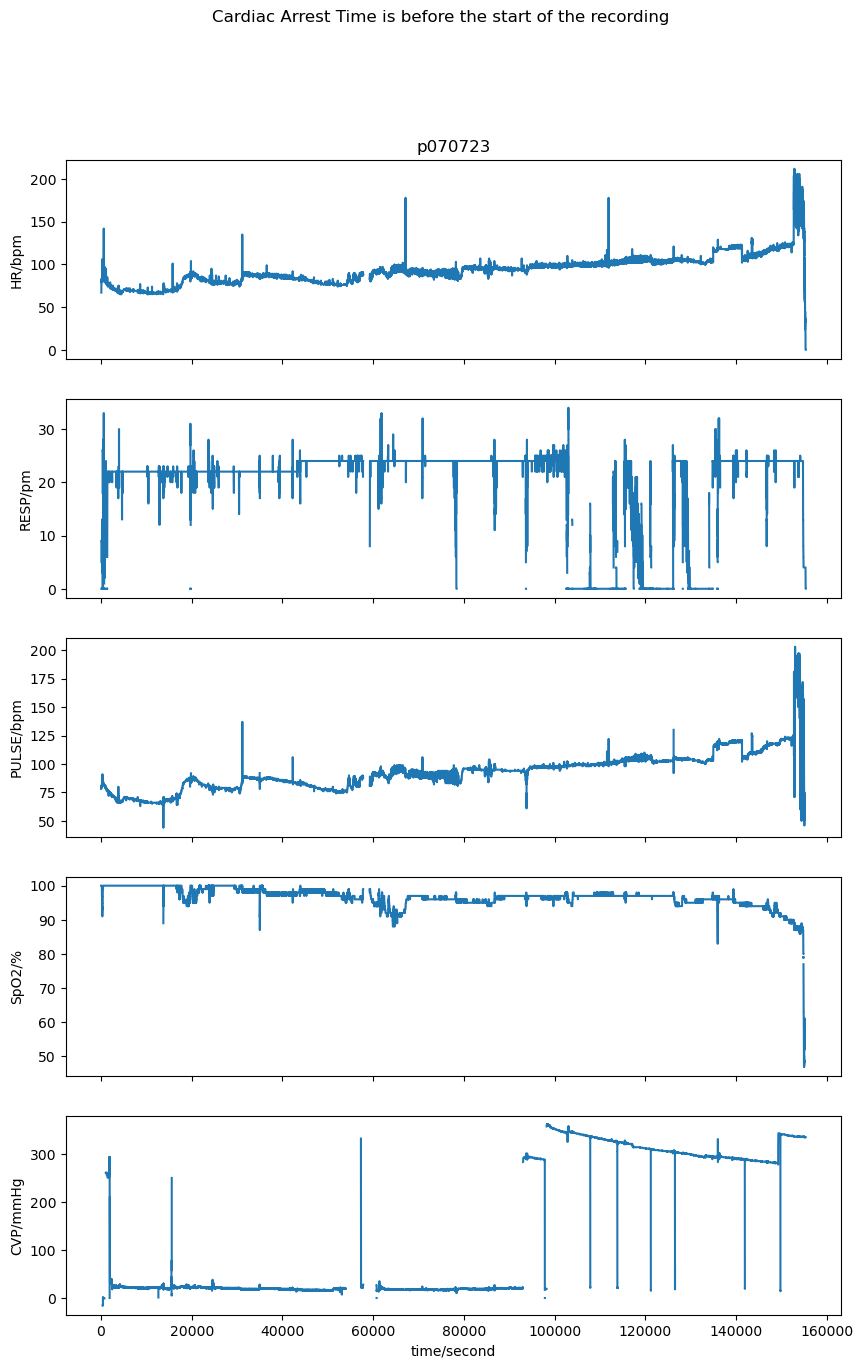

In [52]:
# This patient had cardiac arrest.
# though it states here that cardiac arrest time is before time of recording, it's probably a mismatch
# the patient died at the end.
plot_waveform(patient_id = 70723, ca_time_str = '2163-11-18 15:06:00', record_name = 'p070723-2163-11-18-16-28n')

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_6192/212398187.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p094255-2139-07-30-15-58n',
 'n_sig': 7,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 83036,
 'base_time': datetime.time(15, 58, 59),
 'base_date': datetime.date(2139, 7, 30),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR',
  'RESP',
  'PULSE',
  'SpO2',
  'NBP Mean',
  'NBP Dias',
  'NBP Sys'],
 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3175813n.dat',
  '3175813n.dat',
  '3175813n.dat',
  '3175813n.dat',
  '3175813n.dat',
  '3175813n.dat',
  '3175813n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None, None],
 'byte_

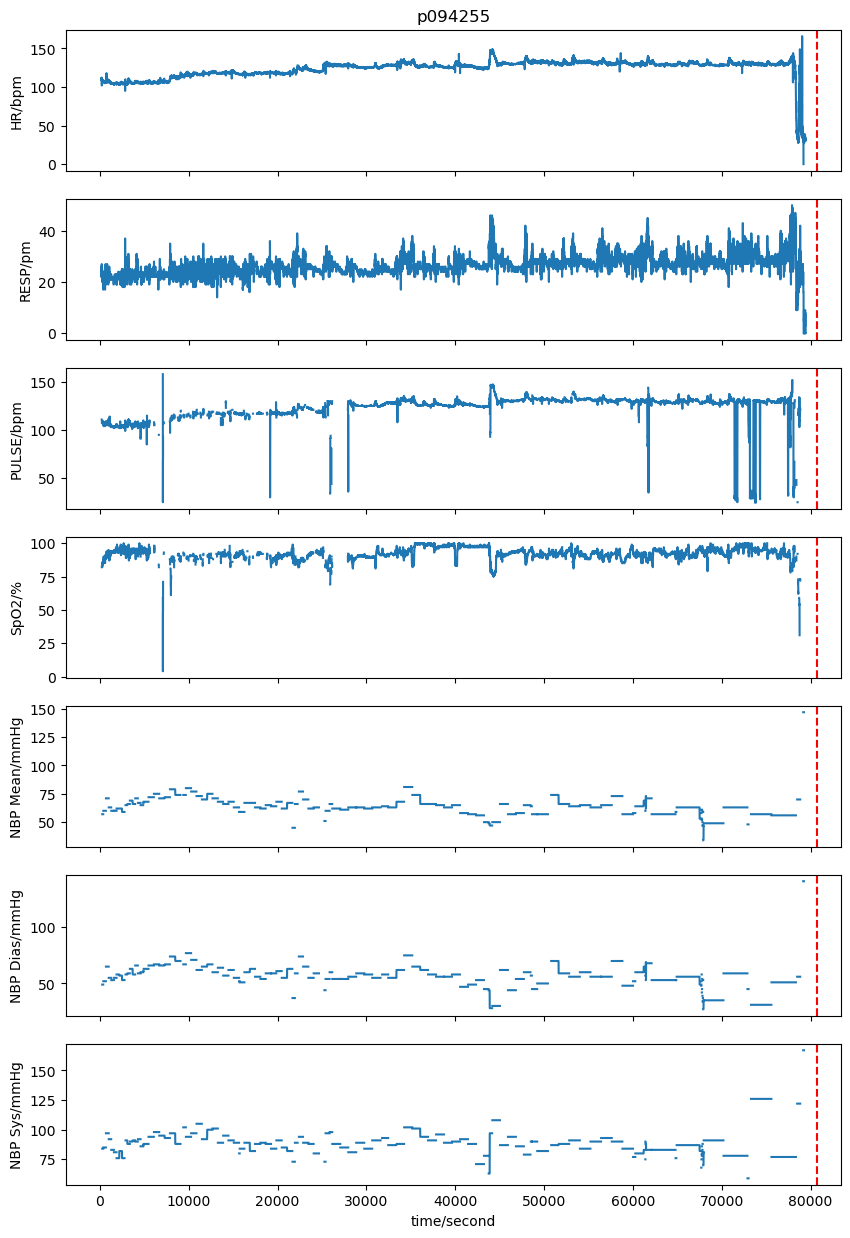

In [51]:
# This patient had cardiac arrest
plot_waveform(patient_id = 94255, ca_time_str = '2139-07-31 14:25:00', record_name = 'p094255-2139-07-30-15-58n')

In [23]:
# This proves that the dataframe is now correct!
# # Creating only matched patients
# noteevents_cardiacarrest = spark.sql(""" 
# SELECT noteevents.* 
# FROM noteevents 
# WHERE lower(DESCRIPTION) LIKE '%cardiac arrest%'""")
# noteevents_cardiacarrest.createOrReplaceTempView('noteevents_cardiacarrest')
# noteevents_cardiacarrest.cache()
# noteevents_cardiacarrest.show()
# noteevents_cardiacarrest.unpersist()

23/04/07 14:51:36 WARN CacheManager: Asked to cache already cached data.
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|  CATEGORY|         DESCRIPTION| CGID|ISERROR|                TEXT|
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+
|364507|     28206| 122503|2198-01-29 00:00:00|Physician |ICU Event Note - ...|19692|   null|TITLE: Cardiac Ar...|
|391100|     21885| 133139|2142-09-14 00:00:00|   General|Cardiac Arrest Co...|18991|   null|TITLE: Cardiac Ar...|
|391094|     21885| 133139|2142-09-14 00:00:00|   General|Cardiac Arrest Co...|18991|   null|TITLE: Cardiac Ar...|
|481809|     94255| 142254|2139-07-31 00:00:00|Physician |Code Blue, Cardia...|14462|   null|TITLE: Code Blue,...|
|506120|     77439| 110528|2148-12-02 00:00:00|   General|Cardiac Arrest Co...|18991|   null|TITLE: Cardiac Ar...|
|651105

DataFrame[ROW_ID: int, SUBJECT_ID: int, HADM_ID: int, CHARTDATE: timestamp, CATEGORY: string, DESCRIPTION: string, CGID: int, ISERROR: string, TEXT: string]

In [36]:
# convert description to lower case and match against cardiac arrest
noteevents_matched_cardiac_desc = spark.sql("""
SELECT noteevents_matched.*
FROM noteevents_matched
WHERE lower(TEXT) LIKE '%cardiac arrest%'
""")                                           
noteevents_matched_cardiac_desc.cache()
noteevents_matched_cardiac_desc.createOrReplaceTempView('noteevents_matched_cardiac_desc')
noteevents_matched_cardiac_desc.show()
noteevents_matched_cardiac_desc.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/noteevents_matched_cardiac_desc', header=True, mode='overwrite')

# More matches!

23/04/07 15:07:20 WARN CacheManager: Asked to cache already cached data.
+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|         CATEGORY|DESCRIPTION|CGID|ISERROR|                TEXT|
+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+
|   840|     31171| 131318|2121-03-26 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|
|   861|     31171| 162332|2121-05-27 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|
|   863|     31171| 109882|2121-11-10 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|
|  1657|     72270| 195344|2181-06-19 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|
|  1181|     25016| 100805|2146-02-09 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|
|   968|     72584| 160386|2200

In [42]:
# convert description to lower case and match against cardiac arrest
noteevents_matched_cardiac_desc_time = spark.sql("""
SELECT noteevents_matched_cardiac_desc.*, noteevents_time.charttime
FROM noteevents_matched_cardiac_desc
LEFT JOIN noteevents_time
ON noteevents_matched_cardiac_desc.ROW_ID = noteevents_time.ROW_ID
""")                                           
# noteevents_matched_cardiac_desc_time.cache()
noteevents_matched_cardiac_desc_time.show()
noteevents_matched_cardiac_desc_time.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/noteevents_matched_cardiac_desc_time', header=True, mode='overwrite')

# however it is not guaranteed that there is a time 

+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|         CATEGORY|DESCRIPTION|CGID|ISERROR|                TEXT|charttime|
+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+---------+
|   840|     31171| 131318|2121-03-26 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|   968|     72584| 160386|2200-04-02 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  1752|     20190| 137000|2139-06-09 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  2066|     20190| 119716|2138-07-31 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|   861|     31171| 162332|2121-05-27 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|   863|     31171| 1098

In [44]:
noteevents_matched_cardiac_desc_time.drop_duplicates().dropna(subset=['charttime']).coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/noteevents_matched_cardiac_desc_time', header=True, mode='overwrite')
# show()

+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|  CATEGORY|         DESCRIPTION| CGID|ISERROR|                TEXT|          charttime|
+------+----------+-------+-------------------+----------+--------------------+-----+-------+--------------------+-------------------+
|314883|     29478| 163798|2103-02-24 00:00:00|Physician |Physician Attendi...|15825|   null|"Chief Complaint:...|2103-02-24 10:05:00|
|335248|     29478| 158944|2103-09-15 00:00:00|Physician |Physician Residen...|20952|   null|Chief Complaint: ...|2103-09-15 07:04:00|
|335332|     29478| 158944|2103-09-15 00:00:00|Physician |Physician Residen...|19669|   null|Chief Complaint: ...|2103-09-15 07:04:00|
|343180|     31171| 109882|2121-11-01 00:00:00|   Nursing|Nursing Progress ...|16948|   null|34 y/o F w/ exten...|2121-11-01 10:40:00|
|343207|     31171| 109882|2121-11-01 00:00:00|   Nursi

# checking notes for the keyword "pulmonary arrest"

In [56]:
## Get "Pulmonary arrest"
noteevents_matched_pulm_desc = spark.sql("""
SELECT noteevents_matched.*, noteevents_time.CHARTTIME
FROM noteevents_matched
LEFT JOIN noteevents_time
ON noteevents_matched.ROW_ID = noteevents_time.ROW_ID
WHERE lower(TEXT) LIKE '%pulmonary arrest%'
""")                                           
noteevents_matched_pulm_desc.cache()
noteevents_matched_pulm_desc.createOrReplaceTempView('noteevents_matched_pulm_desc')
noteevents_matched_pulm_desc.show()
noteevents_matched_pulm_desc.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/noteevents_matched_pulm_desc', header=True, mode='overwrite')
23450

23/04/07 15:52:33 WARN MemoryStore: Not enough space to cache rdd_278_0 in memory! (computed 878.1 MiB so far)


+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|         CATEGORY|DESCRIPTION|CGID|ISERROR|                TEXT|CHARTTIME|
+------+----------+-------+-------------------+-----------------+-----------+----+-------+--------------------+---------+
|   980|     63359| 137873|2102-03-06 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  1195|     14266| 111581|2100-12-09 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  7075|     55332| 176336|2193-03-28 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  7146|     12508| 137241|2199-05-29 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
|  8542|     21265| 140906|2152-07-25 00:00:00|Discharge summary|     Report|null|   null|Admission Date:  ...|     null|
| 10900|      4655| 1292

23450

In [ ]:
# One potential patient
plot_waveform(patient_id = 23450, ca_time_str = '2139-07-31 14:25:00', record_name = 'p094255-2139-07-30-15-58n')

# Start with patients in the PROCEDURESMV

In [37]:
# Relevant codes
ICD9_CODE_CARD = "('4275', '4271', '42741', '42742', '9960', '9963', '9962', '3897', '9604', '3966', '3995', '4192', '9670', '9671', '9672')"

spark.sql(f"""SELECT * 
FROM D_ICD_DIAGNOSES
WHERE ICD9_CODE IN {ICD9_CODE_CARD}""").show()

spark.sql(f"""SELECT * 
FROM D_ICD_PROCEDURES
WHERE ICD9_CODE IN {ICD9_CODE_CARD}""").show()

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|  4460|     4271|Parox ventric tac...|Paroxysmal ventri...|
|  4464|    42741|Ventricular fibri...|Ventricular fibri...|
|  4465|    42742| Ventricular flutter| Ventricular flutter|
|  4466|     4275|      Cardiac arrest|      Cardiac arrest|
|  4541|     3897|Deaf, nonspeaking...|Deaf, nonspeaking...|
| 11414|     9962|Malfun neuro devi...|Mechanical compli...|
| 10401|     9604|Poisoning-tetracy...|Poisoning by tetr...|
| 11337|     9670|Poisoning-barbitu...|Poisoning by barb...|
| 11338|     9671|Poisoning-chloral...|Poisoning by chlo...|
| 11339|     9672|Poisoning-paralde...|Poisoning by para...|
+------+---------+--------------------+--------------------+

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+-----

In [38]:
diag_matched_icd9 = spark.sql(f"""SELECT * 
FROM DIAGNOSES_ICD
INNER JOIN MATCHED_PATIENTS
ON DIAGNOSES_ICD.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
WHERE DIAGNOSES_ICD.ICD9_CODE IN {ICD9_CODE_CARD}""")
diag_matched_icd9.cache()
diag_matched_icd9.show()


+------+----------+-------+-------+---------+----------+
|ROW_ID|SUBJECT_ID|HADM_ID|SEQ_NUM|ICD9_CODE|SUBJECT_ID|
+------+----------+-------+-------+---------+----------+
|   635|        79| 181542|      2|     4271|        79|
|   212|        30| 104557|      5|     4271|        30|
|  2417|       194| 124794|      5|     4275|       194|
|  2418|       194| 124794|      6|     4271|       194|
|  3745|       318| 193264|      3|    42741|       318|
|  1383|       109| 189332|     10|     4275|       109|
|  4317|       357| 145674|     10|     4271|       357|
|  3927|       333| 160548|      2|     4271|       333|
|  5198|       427| 101274|      4|     4271|       427|
|  5795|       491| 157083|      4|     4275|       491|
|  7669|       668| 166245|      2|     4275|       668|
|  8127|       710| 114242|      3|     4275|       710|
|  6396|       543| 115307|      2|     4275|       543|
|  6398|       543| 115307|      4|    42741|       543|
|  6399|       543| 115307|    

# 3. Use Procedures to match cardiac arrest

In [9]:
# These are all the patients with cardiac arrest and their timing
procedures_matched = spark.sql("""SELECT PROCEDUREEVENTS_MV.* 
FROM PROCEDUREEVENTS_MV 
INNER JOIN MATCHED_PATIENTS 
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
""")
procedures_matched.cache()

procedures_matched_cardio = spark.sql("""SELECT PROCEDUREEVENTS_MV.* 
FROM PROCEDUREEVENTS_MV 
INNER JOIN MATCHED_PATIENTS 
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
WHERE ITEMID == 225466 -- This is cardiac arrest 
ORDER BY SUBJECT_ID, STARTTIME
""")
procedures_matched_cardio.show() 

procedures_matched_cardio.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/procedures_matched_cardio', header=True, mode='overwrite')


+------+----------+-------+----------+-------------------+-------------------+------+-----+--------+--------+----------------+-------------------+-----+-------+-----------+------------------+--------------------------+------------------------+---------+------------------+------------+-----------------+-----------------+-------------------+-------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          STARTTIME|            ENDTIME|ITEMID|VALUE|VALUEUOM|LOCATION|LOCATIONCATEGORY|          STORETIME| CGID|ORDERID|LINKORDERID| ORDERCATEGORYNAME|SECONDARYORDERCATEGORYNAME|ORDERCATEGORYDESCRIPTION|ISOPENBAG|CONTINUEINNEXTDEPT|CANCELREASON|STATUSDESCRIPTION|COMMENTS_EDITEDBY|COMMENTS_CANCELEDBY|      COMMENTS_DATE|
+------+----------+-------+----------+-------------------+-------------------+------+-----+--------+--------+----------------+-------------------+-----+-------+-----------+------------------+--------------------------+------------------------+---------+------------------+----

## 3.1 Match procedures with records that might be close enough.

In [58]:
# Find patients with a corresponding record
procedures_matched_cardio_waveform = spark.sql("""SELECT 
PROCEDUREEVENTS_MV.ROW_ID,
PROCEDUREEVENTS_MV.SUBJECT_ID,
PROCEDUREEVENTS_MV.HADM_ID,
PROCEDUREEVENTS_MV.ICUSTAY_ID,
PROCEDUREEVENTS_MV.STARTTIME,
-- PROCEDUREEVENTS_MV.ENDTIME, ignore this endtime (always 1 minute from starttime)
PROCEDUREEVENTS_MV.ITEMID,
PATIENT_BASETIME.BASETIME,
datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) DIFF,
PATIENT_BASETIME.RECORDNAME 

FROM PROCEDUREEVENTS_MV 
INNER JOIN MATCHED_PATIENTS 
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
INNER JOIN PATIENT_BASETIME
ON PROCEDUREEVENTS_MV.SUBJECT_ID = PATIENT_BASETIME.SUBJECT_ID
AND datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) > -1
AND datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) < 1
WHERE ITEMID == 225466 -- This is cardiac arrest 
ORDER BY SUBJECT_ID, STARTTIME
""")

procedures_matched_cardio_waveform.cache()
procedures_matched_cardio_waveform.show()
procedures_matched_cardio_waveform.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/procedures_matched_cardio_waveform', header=True, mode='overwrite')
procedures_matched_cardio_waveform.createOrReplaceTempView('procedures_matched_cardio_waveform')

+------+----------+-------+----------+-------------------+------+-------------------+----+--------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          STARTTIME|ITEMID|           BASETIME|DIFF|          RECORDNAME|
+------+----------+-------+----------+-------------------+------+-------------------+----+--------------------+
|217566|     41035| 127416|    227118|2135-02-06 16:27:00|225466|2135-02-06 08:02:00|   0|p041035-2135-02-0...|
|236493|     43926| 185036|    270489|2197-05-14 17:28:00|225466|2197-05-14 15:06:00|   0|p043926-2197-05-1...|
|181921|     44298| 134239|    226807|2187-06-28 19:00:00|225466|2187-06-28 23:57:00|   0|p044298-2187-06-2...|
|181922|     44298| 134239|    226807|2187-06-28 19:10:00|225466|2187-06-28 23:57:00|   0|p044298-2187-06-2...|
|253841|     46154| 163315|    252848|2196-07-29 06:00:00|225466|2196-07-29 02:30:00|   0|p046154-2196-07-2...|
|232536|     46927| 185997|    297284|2130-03-10 16:28:00|225466|2130-03-10 11:48:00|   0|p046927-2130-0

Nice, we can download these and use them as labeled data.

In [59]:
patients_w_waveform = procedures_matched_cardio_waveform.select('SUBJECT_ID').rdd.flatMap(lambda x: x).collect()
patients_w_waveform = list(set(patients_w_waveform))

In [60]:
print(patients_w_waveform)

[44298, 63762, 43926, 86678, 83873, 54183, 99756, 52529, 96305, 82104, 96060, 70723, 46154, 41035, 46927, 82512, 50015, 60659, 62323, 56697, 87675]


In [61]:
# # Bringing this elsewhere to run
# patients_w_waveform = [44298, 63762, 43926, 86678, 83873, 54183, 99756, 52529, 96305, 82104, 96060, 70723, 46154, 41035, 46927, 82512, 50015, 60659, 62323, 56697, 87675]

# #  Download the waveform file of all patients in matched dataset
# cmd = f"cd .. "
# idx=0
# # Download all the patient records in parallel
# while idx <= len(patients_w_waveform) -1:
#     patient = patientid_to_path(patients_w_waveform[idx])
#     cmd += f"&& /Users/michaelscott/opt/anaconda3/bin/wget -r -N -c -np https://physionet.org/files/mimic3wdb-matched/1.0/{patient[0:3]}/{patient}/ -P data/waveform"
#     if idx%10==0:
#         print(f'Done with {idx}!')
#         process = subprocess.Popen(cmd, shell=True)
#     idx+=1  

# process = subprocess.Popen(cmd, shell=True)


In [62]:
# Now that we've downloaded the files, we can determine the ending time of the file
relevant_records = procedures_matched_cardio_waveform.select('RECORDNAME').rdd.flatMap(lambda x:x).collect()
print(relevant_records)

['p041035-2135-02-06-08-02n', 'p043926-2197-05-14-15-06n', 'p044298-2187-06-28-23-57n', 'p044298-2187-06-28-23-57n', 'p046154-2196-07-29-02-30n', 'p046927-2130-03-10-11-48n', 'p050015-2138-12-20-19-42n', 'p052529-2184-03-10-11-01n', 'p052529-2184-03-10-13-16n', 'p054183-2165-09-27-20-05n', 'p056697-2164-08-21-06-43n', 'p060659-2128-05-24-01-01n', 'p062323-2189-10-01-00-11n', 'p063762-2181-12-04-07-51n', 'p063762-2181-12-04-03-58n', 'p063762-2181-12-04-07-51n', 'p063762-2181-12-04-03-58n', 'p063762-2181-12-04-07-51n', 'p063762-2181-12-04-03-58n', 'p070723-2163-11-18-16-28n', 'p082104-2177-04-29-16-16n', 'p082512-2114-12-22-08-46n', 'p082512-2114-12-22-09-16n', 'p083873-2143-04-16-06-49n', 'p086678-2196-06-07-00-34n', 'p087675-2104-12-05-03-53n', 'p096060-2112-12-16-14-20n', 'p096305-2158-11-01-12-24n', 'p099756-2191-12-23-02-00n', 'p099756-2191-12-23-02-00n']


In [63]:
def get_record(record_name):
    patient_path = get_waveform_path(record_name)
    return wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

def get_ending_time(record_name):
	"""Ending time is the end time of a record"""
	# Get waveform data
	record = get_record(record_name)
	
	# # Version1: Retrieve the ending time as the time using basetime + numrecords
	# # get time when recording started
	# base_time = datetime.datetime.combine(record.__dict__['base_date'], 
	#                         record.__dict__['base_time'])
	
	# duration = record.__dict__['sig_len'] * (1/record.__dict__['fs']) 

	# # Add duration to base time
	# end_time = base_time + datetime.timedelta(seconds=duration)
	
	# # Version 2: Retrieve the ending time as the final valid index in the dataframe
	# I think this is more accurate. We'll go with this.
	record_df = record.to_dataframe()
	
	end_time = record_df.last_valid_index().strftime('%Y-%m-%d-%H-%M')

	record_present = [0 for i in range(len(cfg['CHANNEL_NAMES']))]

	# One hot encode the presence of signals
	for idx, val in enumerate(cfg['CHANNEL_NAMES']):
		if val in record.__dict__['sig_name']:
			record_present[idx] = 1

	return end_time, record_present

In [68]:
relevant_records = ['p041035-2135-02-06-08-02n',
 'p043926-2197-05-14-15-06n',
 'p044298-2187-06-28-23-57n',
 'p044298-2187-06-28-23-57n',
 'p046154-2196-07-29-02-30n',
 'p046927-2130-03-10-11-48n',
 'p050015-2138-12-20-19-42n',
 'p052529-2184-03-10-13-16n',
 'p052529-2184-03-10-11-01n',
 'p054183-2165-09-27-20-05n',
 'p056697-2164-08-21-06-43n',
 'p060659-2128-05-24-01-01n',
 'p062323-2189-10-01-00-11n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p070723-2163-11-18-16-28n',
 'p082104-2177-04-29-16-16n',
 'p082512-2114-12-22-09-16n',
 'p082512-2114-12-22-08-46n',
 'p083873-2143-04-16-06-49n',
 'p086678-2196-06-07-00-34n',
 'p087675-2104-12-05-03-53n',
 'p096060-2112-12-16-14-20n',
 'p096305-2158-11-01-12-24n',
 'p099756-2191-12-23-02-00n',
 'p099756-2191-12-23-02-00n']

# Initialize an empty list to store the rows
patientsendtime_rows = []

# Iterate over each RECORDS file
for record in relevant_records:
    try:
        # get ending time of the record
        endtime, record_present_arr = get_ending_time(record)

        # Retrieve only the numeric data
        patient_id = int(record[1:7])

        # Add the row to the list
        cur_record = [patient_id, record, endtime]
        cur_record.extend(record_present_arr)
        patientsendtime_rows.append(cur_record)
        
    except FileNotFoundError as e:
        print(f'record {record}: {e}')

    except TypeError as e:
        print(f'record {record}: {e}')
    
    except:
        print(f'record {record}')

# Convert the list of rows to a PySpark DataFrame
PATIENT_ENDTIME = spark.createDataFrame(patientsendtime_rows, patientsendtime_schema)
PATIENT_ENDTIME = PATIENT_ENDTIME.withColumn("FINISHTIME", to_timestamp(PATIENT_ENDTIME['FINISHTIME'], 'yyyy-MM-dd-HH-mm'))

# Show the DataFrame
PATIENT_ENDTIME.show()
PATIENT_ENDTIME.createOrReplaceTempView('PATIENT_ENDTIME')
PATIENT_ENDTIME.cache()
PATIENT_ENDTIME.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/PATIENT_ENDTIME', header=True, mode='overwrite')


# next step: 
# 1. Continue from here, and set up a table where you can retrieve 
# the start time and end time and other required properties

# 2. Move this file, and all data to within docker 
# /Users/michaelscott/bd4h/project/streaming-env/time-series-kafka-demo/data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p04/p041035/p041035-2135-02-01-19-56n.hea
# '/Users/michaelscott/bd4h/project/streaming-env/time-series-kafka-demo/data/waveform/physionet.org/files/mimic3wdb-matched/1.0/pp0/pp041035/p041035-2135-02-06-08-02n.hea'

record p063762-2181-12-04-07-51n
record p063762-2181-12-04-07-51n
record p063762-2181-12-04-07-51n
+----------+--------------------+-------------------+---+----+-----+-----+----+---+----+--------+--------+-------+
|SUBJECT_ID|          RECORDNAME|         FINISHTIME| HR|RESP|PULSE|etco2|SpO2|CVP|AWRR|NBP_MEAN|NBP_DIAS|NBp_SYS|
+----------+--------------------+-------------------+---+----+-----+-----+----+---+----+--------+--------+-------+
|     41035|p041035-2135-02-0...|2135-02-06 11:14:00|  1|   1|    1|    0|   1|  0|   0|       1|       1|      1|
|     43926|p043926-2197-05-1...|2197-05-17 17:16:00|  1|   1|    1|    0|   0|  1|   0|       0|       0|      0|
|     44298|p044298-2187-06-2...|2187-07-03 14:21:00|  1|   1|    1|    0|   0|  1|   0|       0|       0|      0|
|     44298|p044298-2187-06-2...|2187-07-03 14:21:00|  1|   1|    1|    0|   0|  1|   0|       0|       0|      0|
|     46154|p046154-2196-07-2...|2196-07-29 06:47:00|  1|   1|    1|    0|   1|  0|   0|       1

In [77]:
procedures_matched_cardio_waveform_start = spark.sql(F"""select DISTINCT procedures_matched_cardio_waveform.*, 
patient_endtime.FINISHTIME,
{','.join([i.replace(' ','_') for i in cfg['CHANNEL_NAMES']])}
from procedures_matched_cardio_waveform
left join PATIENT_ENDTIME
on procedures_matched_cardio_waveform.recordname = PATIENT_ENDTIME.recordname
ORDER BY SUBJECT_ID, STARTTIME
""")

procedures_matched_cardio_waveform_start.show()

# This contains the waveform that we can use to create the training / testing data
procedures_matched_cardio_waveform_start.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/procedures_matched_cardio_waveform_start', header=True, mode='overwrite')



+------+----------+-------+----------+-------------------+------+-------------------+----+--------------------+-------------------+----+----+-----+-----+----+----+----+--------+--------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          STARTTIME|ITEMID|           BASETIME|DIFF|          RECORDNAME|         FINISHTIME|  HR|RESP|PULSE|etco2|SpO2| CVP|AWRR|NBP_Mean|NBP_Dias|NBP_Sys|
+------+----------+-------+----------+-------------------+------+-------------------+----+--------------------+-------------------+----+----+-----+-----+----+----+----+--------+--------+-------+
|217566|     41035| 127416|    227118|2135-02-06 16:27:00|225466|2135-02-06 08:02:00|   0|p041035-2135-02-0...|2135-02-06 11:14:00|   1|   1|    1|    0|   1|   0|   0|       1|       1|      1|
|236493|     43926| 185036|    270489|2197-05-14 17:28:00|225466|2197-05-14 15:06:00|   0|p043926-2197-05-1...|2197-05-17 17:16:00|   1|   1|    1|    0|   0|   1|   0|       0|       0|      0|
|181921|     44298| 13423

In [75]:
cfg["EXPLOREPATH"]

'//Users/michaelscott/bd4h/project/streaming-env/time-series-kafka-demo/explore_output'

In [ ]:
#bookmark

In [231]:
# Find patients with a corresponding record
procedures_matched_cardio_waveform_endtime = spark.sql("""SELECT 
PROCEDUREEVENTS_MV.ROW_ID,
PROCEDUREEVENTS_MV.SUBJECT_ID,
PROCEDUREEVENTS_MV.HADM_ID,
PROCEDUREEVENTS_MV.ICUSTAY_ID,
PROCEDUREEVENTS_MV.STARTTIME,
PROCEDUREEVENTS_MV.ENDTIME,
PROCEDUREEVENTS_MV.ITEMID,
PATIENT_BASETIME.BASETIME,
datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) DIFF,
PATIENT_BASETIME.RECORDNAME,
PATIENT_ENDTIME.*

FROM PROCEDUREEVENTS_MV 
INNER JOIN MATCHED_PATIENTS 
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
INNER JOIN PATIENT_BASETIME
ON PROCEDUREEVENTS_MV.SUBJECT_ID = PATIENT_BASETIME.SUBJECT_ID
AND datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) > -1
AND datediff(PROCEDUREEVENTS_MV.STARTTIME,PATIENT_BASETIME.BASETIME) < 1
LEFT JOIN PATIENT_ENDTIME
ON PATIENT_BASETIME.RECORDNAME = PATIENT_ENDTIME.RECORDNAME
WHERE ITEMID == 225466 -- This is cardiac arrest 
ORDER BY PROCEDUREEVENTS_MV.SUBJECT_ID, PROCEDUREEVENTS_MV.STARTTIME
""")

procedures_matched_cardio_waveform_endtime.cache()

procedures_matched_cardio_waveform_endtime.show()

procedures_matched_cardio_waveform_endtime.coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/procedures_matched_cardio_waveform_endtime', header=True, mode='overwrite')


AnalysisException: Table or view not found: PATIENT_ENDTIME; line 21 pos 10;
'Sort ['PROCEDUREEVENTS_MV.SUBJECT_ID ASC NULLS FIRST, 'PROCEDUREEVENTS_MV.STARTTIME ASC NULLS FIRST], true
+- 'Project ['PROCEDUREEVENTS_MV.ROW_ID, 'PROCEDUREEVENTS_MV.SUBJECT_ID, 'PROCEDUREEVENTS_MV.HADM_ID, 'PROCEDUREEVENTS_MV.ICUSTAY_ID, 'PROCEDUREEVENTS_MV.STARTTIME, 'PROCEDUREEVENTS_MV.ENDTIME, 'PROCEDUREEVENTS_MV.ITEMID, 'PATIENT_BASETIME.BASETIME, 'datediff('PROCEDUREEVENTS_MV.STARTTIME, 'PATIENT_BASETIME.BASETIME) AS DIFF#21285, 'PATIENT_BASETIME.RECORDNAME, ArrayBuffer(PATIENT_ENDTIME).*]
   +- 'Filter ('ITEMID = 225466)
      +- 'Join LeftOuter, ('PATIENT_BASETIME.RECORDNAME = 'PATIENT_ENDTIME.RECORDNAME)
         :- Join Inner, (((SUBJECT_ID#5212 = SUBJECT_ID#20310) AND (datediff(cast(STARTTIME#5215 as date), cast(BASETIME#20316 as date)) > -1)) AND (datediff(cast(STARTTIME#5215 as date), cast(BASETIME#20316 as date)) < 1))
         :  :- Join Inner, (SUBJECT_ID#5212 = SUBJECT_ID#2092)
         :  :  :- SubqueryAlias procedureevents_mv
         :  :  :  +- View (`PROCEDUREEVENTS_MV`, [ROW_ID#5211,SUBJECT_ID#5212,HADM_ID#5213,ICUSTAY_ID#5214,STARTTIME#5215,ENDTIME#5216,ITEMID#5217,VALUE#5218,VALUEUOM#5219,LOCATION#5220,LOCATIONCATEGORY#5221,STORETIME#5222,CGID#5223,ORDERID#5224,LINKORDERID#5225,ORDERCATEGORYNAME#5226,SECONDARYORDERCATEGORYNAME#5227,ORDERCATEGORYDESCRIPTION#5228,ISOPENBAG#5229,CONTINUEINNEXTDEPT#5230,CANCELREASON#5231,STATUSDESCRIPTION#5232,COMMENTS_EDITEDBY#5233,COMMENTS_CANCELEDBY#5234,COMMENTS_DATE#5235])
         :  :  :     +- Relation [ROW_ID#5211,SUBJECT_ID#5212,HADM_ID#5213,ICUSTAY_ID#5214,STARTTIME#5215,ENDTIME#5216,ITEMID#5217,VALUE#5218,VALUEUOM#5219,LOCATION#5220,LOCATIONCATEGORY#5221,STORETIME#5222,CGID#5223,ORDERID#5224,LINKORDERID#5225,ORDERCATEGORYNAME#5226,SECONDARYORDERCATEGORYNAME#5227,ORDERCATEGORYDESCRIPTION#5228,ISOPENBAG#5229,CONTINUEINNEXTDEPT#5230,CANCELREASON#5231,STATUSDESCRIPTION#5232,COMMENTS_EDITEDBY#5233,COMMENTS_CANCELEDBY#5234,COMMENTS_DATE#5235] csv
         :  :  +- SubqueryAlias matched_patients
         :  :     +- View (`matched_patients`, [SUBJECT_ID#2092])
         :  :        +- Deduplicate [SUBJECT_ID#2092]
         :  :           +- Project [cast(SUBJECT_ID#2089 as int) AS SUBJECT_ID#2092]
         :  :              +- Project [substring(value#2087, 6, 6) AS SUBJECT_ID#2089]
         :  :                 +- Relation [value#2087] text
         :  +- SubqueryAlias patient_basetime
         :     +- View (`PATIENT_BASETIME`, [SUBJECT_ID#20310,BASETIME#20316,RECORDNAME#20312])
         :        +- Project [SUBJECT_ID#20310, to_timestamp(BASETIME#20311, Some(yyyy-MM-dd-HH-mm), TimestampType, Some(Asia/Kuala_Lumpur)) AS BASETIME#20316, RECORDNAME#20312]
         :           +- LogicalRDD [SUBJECT_ID#20310, BASETIME#20311, RECORDNAME#20312], false
         +- 'UnresolvedRelation [PATIENT_ENDTIME], [], false


In [ ]:
# With this table, I can then extract the waveform data for each patient

In [ ]:
recordname

['p041035-2135-02-06-08-02n',
 'p043926-2197-05-14-15-06n',
 'p044298-2187-06-28-23-57n',
 'p044298-2187-06-28-23-57n',
 'p046154-2196-07-29-02-30n',
 'p046927-2130-03-10-11-48n',
 'p050015-2138-12-20-19-42n',
 'p052529-2184-03-10-13-16n',
 'p052529-2184-03-10-11-01n',
 'p054183-2165-09-27-20-05n',
 'p056697-2164-08-21-06-43n',
 'p060659-2128-05-24-01-01n',
 'p062323-2189-10-01-00-11n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p063762-2181-12-04-03-58n',
 'p063762-2181-12-04-07-51n',
 'p070723-2163-11-18-16-28n',
 'p082104-2177-04-29-16-16n',
 'p082512-2114-12-22-09-16n',
 'p082512-2114-12-22-08-46n',
 'p083873-2143-04-16-06-49n',
 'p086678-2196-06-07-00-34n',
 'p087675-2104-12-05-03-53n',
 'p096060-2112-12-16-14-20n',
 'p096305-2158-11-01-12-24n',
 'p099756-2191-12-23-02-00n',
 'p099756-2191-12-23-02-00n']

. .......... ......... .......... ..... .......... 77% 4.92K 2m1s
 22700K .......... .............. .......... 77% 4.63K 2m0s
 22750K .......... ........ .......... ............. ............. .......... 77% 64.8K 2m0s
 22750K ... 71% 4.39K 3m5s
 20800K .......... ............. .......... .......... .......... .......... 78% 95.8K 1m59s
 22800K .......... ........... ............. .......... .......... .............. .......... .......... ........ 78% 43.6K 1m59s
 22800K .......... ........ 78%  112K 1m58s
 22850K .......... ... .......... ............. ............. 71% 47.5K 3m4s
 20850K .......... ....... .......... ......... ......... .......... .......... 78% 41.6K 1m57s
 22900K .......... .......... ................ .......... .......... ..... .......... ........... 78% 97.4K 1m56s
 22950K ............ 78% 24.8K 1m59s
 22850K .......... .... ............. 71% 29.8K 3m3s
 20900K ..... .................. .......... . .......... .......... .......... .......... 71% 6.22K 3m6s
 20950

In [175]:
# process.terminate()

## 3.2 Match procedures with notes 

In [94]:
# Find the notes of those who have cardiac arrest
# These are all the patients with cardiac arrest and their timing
procedures_matched_card_notes = spark.sql("""SELECT 
PROCEDUREEVENTS_MV.*, NOTEEVENTS.DESCRIPTION, NOTEEVENTS.CATEGORY, NOTEEVENTS.TEXT, NOTEEVENTS.CHARTDATE, NOTEEVENTS_TIME.CHARTTIME
FROM PROCEDUREEVENTS_MV 
INNER JOIN MATCHED_PATIENTS 
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
LEFT JOIN NOTEEVENTS
ON PROCEDUREEVENTS_MV.HADM_ID = NOTEEVENTS.HADM_ID
LEFT JOIN NOTEEVENTS_TIME
ON NOTEEVENTS.ROW_ID = NOTEEVENTS_TIME.ROW_ID
WHERE PROCEDUREEVENTS_MV.ITEMID == 225466
ORDER BY PROCEDUREEVENTS_MV.SUBJECT_ID, PROCEDUREEVENTS_MV.HADM_ID, PROCEDUREEVENTS_MV.STARTTIME, NOTEEVENTS_TIME.CHARTTIME
""")
procedures_matched_card_notes.cache()
procedures_matched_card_notes.show()
procedures_matched_card_notes.drop_duplicates().coalesce(1).write.csv(f'file://{cfg["EXPLOREPATH"]}/procedures_matched_card_notes', header=True, mode='overwrite')


+------+----------+-------+----------+-------------------+-------------------+------+-----+--------+--------+----------------+-------------------+-----+-------+-----------+------------------+--------------------------+------------------------+---------+------------------+------------+-----------------+-----------------+-------------------+-------------+-----------+-----------------+--------------------+-------------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          STARTTIME|            ENDTIME|ITEMID|VALUE|VALUEUOM|LOCATION|LOCATIONCATEGORY|          STORETIME| CGID|ORDERID|LINKORDERID| ORDERCATEGORYNAME|SECONDARYORDERCATEGORYNAME|ORDERCATEGORYDESCRIPTION|ISOPENBAG|CONTINUEINNEXTDEPT|CANCELREASON|STATUSDESCRIPTION|COMMENTS_EDITEDBY|COMMENTS_CANCELEDBY|COMMENTS_DATE|DESCRIPTION|         CATEGORY|                TEXT|          CHARTDATE|CHARTTIME|
+------+----------+-------+----------+-------------------+-------------------+------+-----+--------+--------+----------------+

In [ ]:
# Alright, let's just create a script
# We will check if the record of a patient is within 24 hour +- of the record STARTTIME of PROCEDUREEVENTS_MV

# find the record of the patient and the start time of each record
# download all the "RECORDS" file from the website

In [ ]:
spark.sql("""SELECT D_ICD_DIAGNOSES.* 
FROM D_ICD_DIAGNOSES
WHERE ICD9_CODE IN """).show()


In [59]:
# Filter 
# Filter the above icd9codes from d_icd_procedures
d_icd_procedures_filtered = d_icd_procedures.filter(d_icd_procedures.ICD9_CODE.isin(icd9_codes))

# Filter teh above icd9_codes from d_icd_diagnosis
d_icd_diagnoses_filtered = D_ICD_DIAGNOSES.filter(d_icd_diagnoses.ICD9_CODE.isin(icd9_codes))
CARD_ICD_9 =["4275", "4271", "42741", "42742", "99.60", "99.63", "99.62", "38.97", "96.04", "39.66", "39.95", "41.92", "96.70", "96.71", "96.72"]

spark.sql("""SELECT * 
FROM D_ICD_DIAGNOSES
WHERE ICD_9_CODE IN ('4275', '4271', '42741', '42742', '99.60', '99.63', '99.62', '38.97', '96.04', '39.66', '39.95', '41.92', '96.70', '96.71', '96.72')""").show()
# 
d_icd_procedures.createOrReplaceTempView('d_icd_procedures')
d_icd_diagnoses.createOrReplaceTempView('d_icd_diagnoses')
d_icd_procedures_filtered.createOrReplaceTempView('d_icd_procedures_filtered')
d_icd_diagnoses_filtered.createOrReplaceTempView('d_icd_diagnoses_filtered')
# Filter the above from d_icd_procedures


NameError: name 'd_icd_procedures' is not defined

In [57]:
spark.sql(""" 
SELECT PROCEDUREEVENTS_MV.* 
FROM PROCEDUREEVENTS_MV
INNER JOIN MATCHED_PATIENTS
ON PROCEDUREEVENTS_MV.SUBJECT_ID = MATCHED_PATIENTS.SUBJECT_ID
INNER JOIN

SyntaxError: EOF while scanning triple-quoted string literal (351411799.py, line 3)

In [29]:


NOTEEVENTS_ORIG = ps.from_pandas(NOTEEVENTS_ORIG)

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_6192/2674808026.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  NOTEEVENTS_ORIG = pd.read_csv(f'{MIMICPATH}/NOTEEVENTS_ORIG.csv.gz',usecols=['ROW_ID','CHARTTIME','STORETIME'])
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [


23/04/07 14:58:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [69]:
# Create schema for d_icd_procedures

# d_icd_procedures = spark.read.csv(f'{MIMICPATH}/D_ICD_PROCEDURES.csv.gz', header=True, schema=d_icd_procedures_schema)

# d_icd_procedures.createOrReplaceTempView('d_icd_procedures')

    
# datetimeevents = spark.read.csv(f'{MIMICPATH}/DATETIMEEVENTS.csv.gz', header=True, schema=datetimeevents_schema)

# datetimeevents.createOrReplaceTempView('datetimeevents')

In [90]:
# d_items_df.createOrReplaceTempView('d_items_df')

In [5]:
# # get pyspark configuration
# from pyspark import SparkConf
# conf = SparkConf()
# print(conf.getAll())

[('spark.executor.memory', '3g'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.app.name', 'Read CSV File into DataFrame'), ('spark.driver.memory', '1g'), ('spark.app.submitTime', '1680836239263'), ('spark.ui.showConsoleProgress', 'true'), ('spark.executor.cores', '4')]


In [5]:
# chartevents = ps.read_csv(f'{MIMICPATH}/CHARTEVENTS.csv.gz', compression='gzip')
#Create schema for chartevents.csv.gz


# chartevents = spark.read.csv(f'{MIMICPATH}/CHARTEVENTS.csv.gz', header=True, inferSchema=True).select('SUBJECT_ID','ITEMID','CHARTTIME','VALUE')

In [ ]:
# chartevents = ps.read_csv(f'{MIMICPATH}/CHARTEVENTS.csv.gz', compression='gzip')
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType
#Create schema for chartevents.csv.gz

chartevents2 = spark.read.csv(f'{cfg["MIMICPATH"]}/CHARTEVENTS.csv.gz', header=True, schema=chartevents_schema)

In [41]:
# define the modified schema for the PySpark DataFrame


noteevents = spark.read.csv(f'{cfg["MIMICPATH"]}/NOTEEVENTS.csv.gz', header=True, schema=noteevents_schema)
# make it sql readable
noteevents.createOrReplaceTempView('noteevents')


In [60]:
# define the modified schema for the PySpark DataFrame
schema = StructType([
    StructField("ROW_ID", IntegerType(), True),
    StructField("SUBJECT_ID", IntegerType(), True),
    StructField("HADM_ID", IntegerType(), True),
    StructField("CHARTDATE", TimestampType(), True),
    StructField("CHARTTIME", TimestampType(), True),
    StructField("STORETIME", TimestampType(), True),
    StructField("CATEGORY", StringType(), True),
    StructField("DESCRIPTION", StringType(), True),
    StructField("CGID", IntegerType(), True),
    StructField("ISERROR", StringType(), True),
    StructField("TEXT", StringType(), True)
])

noteevents2 = spark.read.csv(f'{cfg["MIMICPATH"]}/NOTEEVENTS.csv', header=True, schema=schema)
noteevents2.cache()

# make it sql readable
noteevents2.createOrReplaceTempView('noteevents2')


23/04/07 13:04:31 WARN CacheManager: Asked to cache already cached data.


In [87]:
d_icd_diagnoses.show()

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|   174|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|   175|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|   176|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|   177|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|   178|    01173|TB pneumothorax-m...|Tuberculous pneum...|
|   179|    01174|TB pneumothorax-c...|Tuberculous pneum...|
|   180|    01175|TB pneumothorax-h...|Tuberculous pneum...|
|   181|    01176|TB pneumothorax-o...|Tuberculous pneum...|
|   182|    01180|Pulmonary TB NEC-...|Other specified p...|
|   183|    01181|Pulmonary TB NEC-...|Other specified p...|
|   184|    01182|Pulmon TB NEC-exa...|Other specified p...|
|   185|    01183|Pulmon TB NEC-mic...|Other specified p...|
|   186|    01184|Pulmon TB NEC-cul...|Other specified p...|
|   187|    01185|Pulmon

In [82]:
d_icd_procedures.filter(d_icd_procedures.ICD9_CODE.isin(icd9_codes))

DataFrame[ROW_ID: int, ICD9_CODE: string, SHORT_TITLE: string, LONG_TITLE: string]

In [117]:
spark.sql("select * from d_icd_diagnoses where long_title like '%cardiac%'").show()

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|  4471|    42789|Cardiac dysrhythm...|Other specified c...|
|  4492|     4294|Hrt dis postcardi...|Functional distur...|
|  4495|    42971|Acq cardiac septl...|Acquired cardiac ...|
|  7319|     7458|Septal closure an...|Other bulbus cord...|
|  7338|    74687|Malposition of heart|Malposition of he...|
| 12276|     9720|Pois-card rhythm ...|Poisoning by card...|
|  9881|    V4500|Status cardc dvce...|Unspecified cardi...|
|  9883|    V4502|Status autm crd d...|Automatic implant...|
|  9884|    V4509|Status oth spcf c...|Other specified c...|
| 11407|    99600|Malfunc card dev/...|Mechanical compli...|
| 11408|    99601|Malfunc cardiac p...|Mechanical compli...|
| 11411|    99604|Mch cmp autm mpln...|Mechanical compli...|
| 11412|    99609|Malfunc card dev/...|Other mechanical ...|
| 11437|    99661|React-

In [118]:
spark.sql("select * from d_icd_procedures where long_title like '%cardiac%'").show()

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|   174|     0050|Impl CRT pacemake...|Implantation of c...|
|   175|     0051|Impl CRT defibril...|Implantation of c...|
|   177|     0053|Imp/rep CRT pacem...|Implantation or r...|
|   178|     0054|Imp/rep CRT defib...|Implantation or r...|
|   180|     0056|Ins/rep sens-crd/...|Insertion or repl...|
|   181|     0057|Imp/rep subcue ca...|Implantation or r...|
|   614|     3721|Rt heart cardiac ...|Right heart cardi...|
|   696|     3826|Insrt prsr snsr w...|Insertion of impl...|
|   762|     3964|Intraop cardiac p...|Intraoperative ca...|
|   805|     3722|Left heart cardia...|Left heart cardia...|
|   806|     3723|Rt/left heart car...|Combined right an...|
|   811|     3728|Intracardiac echo...|Intracardiac echo...|
|   971|     1751|Implant CCM,total...|Implantation of r...|
|   972|     1752|Implan

In [119]:
d_icd_procedures_filtered.show()

+------+---------+-----------+----------+
|ROW_ID|ICD9_CODE|SHORT_TITLE|LONG_TITLE|
+------+---------+-----------+----------+
+------+---------+-----------+----------+



In [120]:
d_icd_diagnoses_filtered.show()

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|  4460|     4271|Parox ventric tac...|Paroxysmal ventri...|
|  4464|    42741|Ventricular fibri...|Ventricular fibri...|
|  4466|     4275|      Cardiac arrest|      Cardiac arrest|
+------+---------+--------------------+--------------------+



+----------+
|SUBJECT_ID|
+----------+
|        52|
|       107|
|       109|
|       135|
|       177|
|       263|
|       292|
|       308|
|       317|
|       328|
+----------+
only showing top 10 rows



In [51]:
noteevents_matched = spark.sql(""" 
SELECT * FROM noteevents 
INNER JOIN matched_patients
ON noteevents.SUBJECT_ID = matched_patients.SUBJECT_ID""")
noteevents_matched.createOrReplaceTempView('noteevents_matched')

noteevents_matched.cache()

23/04/07 12:26:04 WARN CacheManager: Asked to cache already cached data.


DataFrame[ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, CHARTDATE: string, CHARTTIME: string, STORETIME: string, CATEGORY: string, DESCRIPTION: string, CGID: string, ISERROR: string, TEXT: string, SUBJECT_ID: int]

23/04/07 14:40:02 WARN CacheManager: Asked to cache already cached data.


DataFrame[ROW_ID: int, SUBJECT_ID: int, HADM_ID: int, CHARTDATE: timestamp, CHARTTIME: timestamp, STORETIME: timestamp, CATEGORY: string, DESCRIPTION: string, CGID: int, ISERROR: string, TEXT: string, SUBJECT_ID: int]

23/04/07 14:37:30 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 11
CSV file: file:///Users/michaelscott/bd4h/project/data/mimic3/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv.gz


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [43]:
noteevents_matched_cardiacarrest.coalesce(1).write.csv('../output/noteevents_matched_cardiacarrest.csv', header=True, mode='overwrite')

AnalysisException: Found duplicate column(s) when inserting into file:/Users/michaelscott/bd4h/project/output/noteevents_matched_cardiacarrest.csv: `subject_id`

In [40]:
# write some query from noteevents
# convert description to lower case and match against cardiac arrest
noteevents_matched_cardiacarrest = spark.sql("""
SELECT noteevents_matched.*
FROM noteevents_matched
WHERE lower(DESCRIPTION) LIKE '%cardiac arrest%'
""")

# print out the result
noteevents_matched_cardiacarrest.show()

# 70723 and 94255 are a match

+------+----------+-------+----------+-------------------+-------------------+----------+--------------------+-----+-------+--------------------+----------+
|ROW_ID|SUBJECT_ID|HADM_ID| CHARTDATE|          CHARTTIME|          STORETIME|  CATEGORY|         DESCRIPTION| CGID|ISERROR|                TEXT|SUBJECT_ID|
+------+----------+-------+----------+-------------------+-------------------+----------+--------------------+-----+-------+--------------------+----------+
|481809|     94255| 142254|2139-07-31|2139-07-31 14:25:00|2139-07-31 14:26:17|Physician |Code Blue, Cardia...|14462|   null|TITLE: Code Blue,...|     94255|
|651105|     70723| 181992|2163-11-18|2163-11-18 15:06:00|2163-11-18 15:06:21|Physician |ICU Event Note - ...|19692|   null|TITLE: Cardiac Ar...|     70723|
+------+----------+-------+----------+-------------------+-------------------+----------+--------------------+-----+-------+--------------------+----------+



In [61]:
# write some query from noteevents
# convert description to lower case and match against cardiac arrest
noteevents2_cardiacarrest = spark.sql("""
SELECT noteevents2.*
FROM noteevents2
WHERE lower(DESCRIPTION) LIKE '%cardiac arrest%'
""")
noteevents2_cardiacarrest.cache()

# print out the result
noteevents2_cardiacarrest.show()

# 70723 and 94255 are a match

23/04/07 13:07:23 WARN MemoryStore: Not enough space to cache rdd_306_7 in memory! (computed 27.6 MiB so far)
23/04/07 13:07:23 WARN BlockManager: Persisting block rdd_306_7 to disk instead.
23/04/07 13:07:43 WARN MemoryStore: Not enough space to cache rdd_306_5 in memory! (computed 64.5 MiB so far)
23/04/07 13:07:43 WARN BlockManager: Persisting block rdd_306_5 to disk instead.
23/04/07 13:07:45 WARN MemoryStore: Not enough space to cache rdd_306_6 in memory! (computed 48.0 MiB so far)
23/04/07 13:07:45 WARN BlockManager: Persisting block rdd_306_6 to disk instead.
23/04/07 13:07:45 WARN MemoryStore: Not enough space to cache rdd_306_8 in memory! (computed 48.0 MiB so far)
23/04/07 13:07:45 WARN BlockManager: Persisting block rdd_306_8 to disk instead.
23/04/07 13:07:45 WARN MemoryStore: Not enough space to cache rdd_306_9 in memory! (computed 48.0 MiB so far)
23/04/07 13:07:45 WARN BlockManager: Persisting block rdd_306_9 to disk instead.


23/04/07 13:08:13 WARN MemoryStore: Not enough space to cache rdd_306_12 in memory! (computed 75.2 MiB so far)
23/04/07 13:08:13 WARN BlockManager: Persisting block rdd_306_12 to disk instead.


23/04/07 13:09:04 WARN MemoryStore: Not enough space to cache rdd_306_5 in memory! (computed 64.5 MiB so far)


23/04/07 13:09:09 WARN MemoryStore: Not enough space to cache rdd_306_11 in memory! (computed 115.9 MiB so far)
23/04/07 13:09:09 WARN BlockManager: Persisting block rdd_306_11 to disk instead.


23/04/07 13:09:36 WARN MemoryStore: Not enough space to cache rdd_306_11 in memory! (computed 115.9 MiB so far)


23/04/07 13:09:38 WARN MemoryStore: Not enough space to cache rdd_306_7 in memory! (computed 48.0 MiB so far)
23/04/07 13:09:38 WARN MemoryStore: Not enough space to cache rdd_306_12 in memory! (computed 75.2 MiB so far)


23/04/07 13:09:40 WARN MemoryStore: Not enough space to cache rdd_306_9 in memory! (computed 75.2 MiB so far)
23/04/07 13:09:41 WARN MemoryStore: Not enough space to cache rdd_306_6 in memory! (computed 75.2 MiB so far)


23/04/07 13:09:41 WARN MemoryStore: Not enough space to cache rdd_306_8 in memory! (computed 27.6 MiB so far)


23/04/07 13:09:55 WARN MemoryStore: Not enough space to cache rdd_306_18 in memory! (computed 14.3 MiB so far)
23/04/07 13:09:55 WARN BlockManager: Persisting block rdd_306_18 to disk instead.
23/04/07 13:09:56 WARN MemoryStore: Not enough space to cache rdd_306_20 in memory! (computed 14.3 MiB so far)
23/04/07 13:09:56 WARN BlockManager: Persisting block rdd_306_20 to disk instead.
23/04/07 13:09:57 WARN MemoryStore: Not enough space to cache rdd_306_13 in memory! (computed 48.0 MiB so far)
23/04/07 13:09:57 WARN BlockManager: Persisting block rdd_306_13 to disk instead.
23/04/07 13:10:07 WARN MemoryStore: Not enough space to cache rdd_306_17 in memory! (computed 28.1 MiB so far)
23/04/07 13:10:07 WARN BlockManager: Persisting block rdd_306_17 to disk instead.
23/04/07 13:10:09 WARN MemoryStore: Not enough space to cache rdd_306_19 in memory! (computed 28.1 MiB so far)
23/04/07 13:10:09 WARN BlockManager: Persisting block rdd_306_19 to disk instead.
23/04/07 13:10:27 WARN MemoryStore:

23/04/07 13:10:49 WARN MemoryStore: Not enough space to cache rdd_306_14 in memory! (computed 75.2 MiB so far)
23/04/07 13:10:49 WARN BlockManager: Persisting block rdd_306_14 to disk instead.
23/04/07 13:11:13 WARN MemoryStore: Not enough space to cache rdd_306_17 in memory! (computed 48.9 MiB so far)


23/04/07 13:11:17 WARN MemoryStore: Not enough space to cache rdd_306_18 in memory! (computed 48.9 MiB so far)
23/04/07 13:11:17 WARN MemoryStore: Not enough space to cache rdd_306_19 in memory! (computed 7.4 MiB so far)
23/04/07 13:11:17 WARN MemoryStore: Not enough space to cache rdd_306_20 in memory! (computed 48.8 MiB so far)


23/04/07 13:11:28 WARN MemoryStore: Not enough space to cache rdd_306_21 in memory! (computed 14.5 MiB so far)
23/04/07 13:11:28 WARN BlockManager: Persisting block rdd_306_21 to disk instead.
23/04/07 13:11:31 WARN MemoryStore: Not enough space to cache rdd_306_23 in memory! (computed 14.3 MiB so far)
23/04/07 13:11:31 WARN BlockManager: Persisting block rdd_306_23 to disk instead.
23/04/07 13:11:44 WARN MemoryStore: Not enough space to cache rdd_306_24 in memory! (computed 23.9 MiB so far)
23/04/07 13:11:44 WARN BlockManager: Persisting block rdd_306_24 to disk instead.
23/04/07 13:11:46 WARN MemoryStore: Not enough space to cache rdd_306_13 in memory! (computed 7.2 MiB so far)


23/04/07 13:11:53 WARN MemoryStore: Not enough space to cache rdd_306_16 in memory! (computed 115.9 MiB so far)
23/04/07 13:11:53 WARN BlockManager: Persisting block rdd_306_16 to disk instead.
23/04/07 13:12:10 WARN MemoryStore: Not enough space to cache rdd_306_16 in memory! (computed 75.2 MiB so far)


23/04/07 13:12:13 WARN MemoryStore: Not enough space to cache rdd_306_14 in memory! (computed 75.2 MiB so far)


23/04/07 13:12:16 WARN MemoryStore: Not enough space to cache rdd_306_15 in memory! (computed 75.2 MiB so far)


23/04/07 13:12:22 WARN MemoryStore: Not enough space to cache rdd_306_22 in memory! (computed 76.8 MiB so far)
23/04/07 13:12:22 WARN BlockManager: Persisting block rdd_306_22 to disk instead.
23/04/07 13:12:34 WARN MemoryStore: Not enough space to cache rdd_306_21 in memory! (computed 77.5 MiB so far)


23/04/07 13:12:35 WARN MemoryStore: Not enough space to cache rdd_306_22 in memory! (computed 76.8 MiB so far)
23/04/07 13:12:35 WARN MemoryStore: Not enough space to cache rdd_306_23 in memory! (computed 28.1 MiB so far)


23/04/07 13:12:54 WARN MemoryStore: Not enough space to cache rdd_306_25 in memory! (computed 17.3 MiB so far)
23/04/07 13:12:54 WARN BlockManager: Persisting block rdd_306_25 to disk instead.
23/04/07 13:12:54 WARN MemoryStore: Not enough space to cache rdd_306_26 in memory! (computed 17.3 MiB so far)
23/04/07 13:12:54 WARN BlockManager: Persisting block rdd_306_26 to disk instead.
23/04/07 13:13:01 WARN MemoryStore: Not enough space to cache rdd_306_28 in memory! (computed 28.0 MiB so far)
23/04/07 13:13:01 WARN BlockManager: Persisting block rdd_306_28 to disk instead.
23/04/07 13:13:15 WARN MemoryStore: Not enough space to cache rdd_306_29 in memory! (computed 48.5 MiB so far)
23/04/07 13:13:15 WARN BlockManager: Persisting block rdd_306_29 to disk instead.
23/04/07 13:13:24 WARN MemoryStore: Not enough space to cache rdd_306_26 in memory! (computed 17.3 MiB so far)
23/04/07 13:13:24 WARN MemoryStore: Not enough space to cache rdd_306_25 in memory! (computed 8.9 MiB so far)


23/04/07 13:13:36 WARN MemoryStore: Not enough space to cache rdd_306_27 in memory! (computed 79.6 MiB so far)
23/04/07 13:13:36 WARN BlockManager: Persisting block rdd_306_27 to disk instead.
23/04/07 13:13:38 WARN MemoryStore: Not enough space to cache rdd_306_27 in memory! (computed 79.6 MiB so far)


23/04/07 13:13:44 WARN MemoryStore: Not enough space to cache rdd_306_28 in memory! (computed 76.3 MiB so far)


23/04/07 13:13:45 WARN MemoryStore: Not enough space to cache rdd_306_29 in memory! (computed 75.8 MiB so far)
+------+----------+-------+-------------------+-------------------+-------------------+--------------------+--------------------+-----+--------------------+--------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|          CHARTDATE|          CHARTTIME|          STORETIME|            CATEGORY|         DESCRIPTION| CGID|             ISERROR|                TEXT|
+------+----------+-------+-------------------+-------------------+-------------------+--------------------+--------------------+-----+--------------------+--------------------+
|364507|     28206| 122503|2198-01-29 00:00:00|2198-01-29 04:13:00|2198-01-29 04:13:34|          Physician |ICU Event Note - ...|19692|                null|TITLE: Cardiac Ar...|
|391100|     21885| 133139|2142-09-14 00:00:00|2142-09-14 18:55:00|2142-09-14 19:18:19|             General|Cardiac Arrest Co...|18991|                null|TITLE: Cardiac Ar...|

In [45]:
cpr_chartevents_mini = chartevents.loc['ITEM_ID' == 4545, ['SUBJECT_ID', 'CHARTTIME']]

23/03/31 16:43:38 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 324.0 MiB so far)
23/03/31 16:43:38 WARN BlockManager: Persisting block rdd_237_0 to disk instead.


23/03/31 16:59:08 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 324.0 MiB so far)


/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [47]:
cpr_chartevents_mini #sweatsmile, there's only one?!

SUBJECT_ID                     36
CHARTTIME     2134-05-12 12:00:00
Name: 0, dtype: object

In [44]:
len(cpr_chartevents_mini)

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [39]:
cpr_chartevents_mini

23/03/31 16:35:09 WARN MemoryStore: Not enough space to cache rdd_225_0 in memory! (computed 340.8 MiB so far)
23/03/31 16:35:09 WARN BlockManager: Persisting block rdd_225_0 to disk instead.


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
noteevents = ps.read_csv(f'{cfg["MIMICPATH"]}/NOTEEVENTS.csv.gz', compression='gzip')

In [36]:
import itertools as IT
import pandas as pd

chunksize = 10 ** 5
chunks = pd.read_csv(f'{cfg["MIMICPATH"]}/CHARTEVENTS.csv.gz', chunksize=chunksize, compression='gzip', usecols=['ROW_ID','SUBJECT_ID','HADM_ID','ICUSTAY_ID','ITEMID','CHARTTIME','VALUENUM'])
# chunks = pd.read_csv(f'/Users/michaelscott/bd4h/project/data/mimic3/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv', chunksize=chunksize)
def valid(chunks):
    for chunk in chunks:
        mask = chunk['ITEMID'] == 4545
        yield chunk.loc[mask]
df = pd.concat(valid(chunks))
cpr_chartevents = df


KeyboardInterrupt: 

In [33]:
df

row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
0       5279021       40124   126179    279554.0  223761  2130-02-04 04:00:00   
73      5279094       40124   126179    279554.0  223761  2130-02-04 08:00:00   
137     5279158       40124   126179    279554.0  223761  2130-02-04 12:00:00   
174     5279195       40124   126179    279554.0  223761  2130-02-04 16:00:00   
208     5279229       40124   126179    279554.0  223761  2130-02-04 20:00:00   
...         ...         ...      ...         ...     ...                  ...   
101273  7469028       44228   103379    217992.0  223761  2170-12-19 00:00:00   
101324  7469079       44228   103379    217992.0  223761  2170-12-19 04:00:00   
101347  7469102       44228   103379    217992.0  223761  2170-12-19 08:00:00   
101388  7469143       44228   103379    217992.0  223761  2170-12-19 12:00:00   
101411  7469166       44228   103379    217992.0  223761  2170-12-19 16:00:00   

                  storetime   cgid value  valuenum valueuom  warning  error  \
0       2130-02-04 04:35:00  19085  95.9      95.9       ?F      0.0    0.0   
73      2130-02-04 07:48:00  21304  96.2      96.2       ?F      0.0    0.0   
137     2130-02-04 12:08:00  21304  95.9      95.9       ?F      0.0    0.0   
174     2130-02-04 16:10:00  21304  95.7      95.7       ?F      0.0    0.0   
208     2130-02-04 20:11:00  21452  96.6      96.6       ?F      0.0    0.0   
...                     ...    ...   ...       ...      ...      ...    ...   
101273  2170-12-19 00:02:00  16890  99.4      99.4       ?F      0.0    0.0   
101324  2170-12-19 04:14:00  16890  98.9      98.9       ?F      0.0    0.0   
101347  2170-12-19 08:18:00  18602  98.6      98.6       ?F      0.0    0.0   
101388  2170-12-19 12:15:00  18602  98.7      98.7       ?F      0.0    0.0   
101411  2170-12-19 17:06:00  18602  98.8      98.8       ?F      0.0    0.0   

       resultstatus stopped  
0               NaN     NaN  
73              NaN     NaN  
137             NaN     NaN  
174             NaN     NaN  
208             NaN     NaN  
...             ...     ...  
101273          NaN     NaN  
101324          NaN     NaN  
101347          NaN     NaN  
101388          NaN     NaN  
101411          NaN     NaN  

[1976 rows x 15 columns]

In [13]:
chartevents2 = ps.read_csv(f'/Users/michaelscott/bd4h/project/data/mimic3/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [16]:
chartevents2.head(5)

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


row_id  subject_id  hadm_id  icustay_id  itemid           charttime           storetime   cgid      value   valuenum  valueuom  warning  error resultstatus stopped
0  5279021       40124   126179      279554  223761 2130-02-04 04:00:00 2130-02-04 04:35:00  19085       95.9       95.9        ?F        0      0         None    None
1  5279022       40124   126179      279554  224695 2130-02-04 04:25:00 2130-02-04 05:55:00  18999  2222221.7  2222221.7     cmH2O        0      0         None    None
2  5279023       40124   126179      279554  220210 2130-02-04 04:30:00 2130-02-04 04:43:00  21452         15       15.0  insp/min        0      0         None    None
3  5279024       40124   126179      279554  220045 2130-02-04 04:32:00 2130-02-04 04:43:00  21452         94       94.0       bpm        0      0         None    None
4  5279025       40124   126179      279554  220179 2130-02-04 04:32:00 2130-02-04 04:43:00  21452        163      163.0      mmHg        0      0         None    None

In [ ]:
chartevents2.head(5).

In [ ]:
ps.read_csv('data.csv')  

In [93]:
from pyspark.sql.functions import lower
d_items_df.selectExpr("*").where(lower("LABEL").like("%cardiac%")).show()

+------+------+--------------------+--------------------+----------+------------------+--------------------+--------+----------+---------+
|ROW_ID|ITEMID|               LABEL|        ABBREVIATION|  DBSOURCE|           LINKSTO|            CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+------+--------------------+--------------------+----------+------------------+--------------------+--------+----------+---------+
|   121|   116|       Cardiac Index|                null|   carevue|       chartevents|                null|    null|      null|     null|
|  1470|  4449|     Cardiac consult|                null|   carevue|       chartevents|                null|    null|      null|     null|
|   966|  3352|        Cardiac Echo|                null|   carevue|       chartevents|                null|    null|      null|     null|
|   967|  3353|      Cardiac Murmur|                null|   carevue|       chartevents|                null|    null|      null|     null|
|   968|  3354|      Cardia

In [95]:
from pyspark.sql.functions import lower
d_items_df.selectExpr("*").where(lower("LABEL").like("%pulmonary%")).show()

+------+------+--------------------+--------------------+----------+--------------+-------------------+--------+----------+---------+
|ROW_ID|ITEMID|               LABEL|        ABBREVIATION|  DBSOURCE|       LINKSTO|           CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+------+--------------------+--------------------+----------+--------------+-------------------+--------+----------+---------+
|     6|  1447| Transpulmonary Pres|                null|   carevue|   chartevents|               null|    null|      null|     null|
|  5336| 30404|    Nutren Pulmonary|                null|   carevue|inputevents_cv|               null|    null|      null|     null|
|  9597| 45151|           Pulmonary|                null|   carevue|inputevents_cv|   Free Form Intake|    null|      null|     null|
|  9614| 45176|NOVASOURCE/PULMONARY|                null|   carevue|inputevents_cv|   Free Form Intake|    null|      null|     null|
|  9725| 45323|        Pulmonary TF|                null|   ca

In [19]:
d_items_df.query('(ITEMID == 220045) OR (ITEMID == 4545)')

ROW_ID  ITEMID       LABEL ABBREVIATION    DBSOURCE      LINKSTO             CATEGORY UNITNAME PARAM_TYPE CONCEPTID
1388     1517    4545         CPR         None     carevue  chartevents                 None     None       None      None
11498   12712  220045  Heart Rate           HR  metavision  chartevents  Routine Vital Signs      bpm    Numeric      None

In [32]:
matched_waveform_patients_df = pd.read_csv(f'{cfg["WAVEFPATH"]}/RECORDS', sep = '/', names=['PATIENTID','b'])\
                                    .reset_index()\
                                    .drop(columns=['index','b'])
matched_waveform_patients_df = matched_waveform_patients_df['PATIENTID'].str.replace('p','')\
                                    .astype(int)
matched_waveform_patients_df



0           20
1           30
2           33
3           52
4           79
         ...  
10277    99955
10278    99982
10279    99983
10280    99992
10281    99999
Name: PATIENTID, Length: 10282, dtype: int64

<!-- diag_df = pd.read_csv(f'{MIMICPATH}/DIAGNOSES_ICD.csv.gz',compression='gzip') -->

Exploration of using Code to detect cardiac arrests:

- `We assessed the proportion of cardiac arrest cases from GWTG-Resuscitation that were identified in corresponding Medicare claims using International Classification of Disease, Ninth Edition, Clinical Modification (ICD-9-CM) diagnosis codes for cardiac arrest (427.5 [cardiac arrest], 427.1 [ventricular tachycardia], 427.41 [ventricular fibrillation], or 427.42 [ventricular flutter]) or procedure codes for cardiopulmonary resuscitation (ICD-9-CM codes 99.60, 99.63) or defibrillation (ICD-9-CM code 99.62).` [Source](https://jamanetwork.com/journals/jamacardiology/fullarticle/2652882)

- ICD-9-CM codes 427.5 (cardiac arrest), 99.60 (cardiopulmonary resuscitation), and 99.63 (closed chest cardiac massage) were abstracted from the electronic medical record (EMR) of patients who were discharged from any VA Medical Center between [Source](https://www.ahajournals.org/doi/10.1161/circoutcomes.8.suppl_2.281) ==> These could all be cardiac arrests.

- So, I extracted subject_id and seq_num from the Procedures_ICD table. Then, subject_id and StartTime and EndTime are extracted from the ProcedureEvents_mv table. Because seq_num is the order of operations I want to be able to match the subject_id and seq_num to get the exact operative time.[Source](https://github.com/MIT-LCP/mimic-code/issues/562)

- In the CHARTEVENTS table, the event code 4545 is associated with an episode of CPR, which typically follows an arrest (unless a patient has a DNR order). Also, in the PROCEDUREEVENTS_MV table, the codes 225475 and 224566 represent cardiac and respiratory arrests, respectively. On manual review, however, not all of these episodes appear as true arrests. On approach may be to mine the text notes to look for a reported history of arrest but I haven't tried that myself. (https://opendata.stackexchange.com/questions/6706/patient-admitted-to-icu-after-cardiac-arrest-post-cardiac-arrest-in-mimic-iii)

- Can use CPT. We compared the types of procedures performed for cardiac arrest by using available Current Procedural Terminology (CPT) or ICD-9 procedure codes used previously.22 We included cardiopulmonary resuscitation (CPR) (CPT 92950 or ICD-9 99.60 or 99.63); central venous catheterization (CPT 36555–36566 or ICD-9 38.97); endotracheal intubation (CPT 31500 or ICD-9 96.04); extracorporeal membrane oxygenation (ECMO) (ICD-9 39.65 or 39.66); hemodialysis (ICD-9 39.95); intraosseous infusion (CPT 36680 or ICD-9 41.92); and mechanical ventilation (CPT 94002–94004 or ICD-9 96.70–96.72). [Source](https://opendata.stackexchange.com/questions/7145/convenient-way-to-get-time-of-surgery-in-mimic-iii)



How other papers have identified cardiac arrests:
- The patient inclusion flowchart is presented in Fig. 1. The
specified anomalous events were first acquired by analyzing multi-
parameter waveform data with the Mindray monitoring analysis al-
gorithm [15], and then confirmed by experts. Patients with at least
one specified anomalous event were recruited in CA group. Non-
CA group was randomly selected from groups without risk of the
specified anomalous events [Source](https://reader.elsevier.com/reader/sd/pii/S0169260721006428?token=388574F86E0105EB2F69ADFB9442B8220891FEE442A9ACE8E3180FA56591722465068EDCEA00B71FF3923BF8C008620B&originRegion=eu-west-1&originCreation=20230318160407)


- The purpose of this retrospective cohort study was to predict
the occurrence of CA in adult patients with sepsis. Out of 7769
sepsis records, 127 CA cases with the registered incidence time
were found. We intended to investigate how much earlier the CA
incidence can be predicted? And can we predict the CA occurrence
earlier than 24 h? In addition, we were interested to examine the
effect of trend features on prediction performance. Therefore, we
needed several hours of patient data before the prediction time.
Considering the CA patients’ lengths of stay, In order to maximize
the number of included samples, the 30-hour interval was selected
as a minimum value for length of stay. Consequently, patients un-
der the age of 15 and those with the length of stay less than 30 h
were excluded from the dataset. In addition, due to the impor-
tance of the time in this study, only cases were selected as car-
diac arrests that the time of the occurrence was recorded and CA
occurred after the diagnosis of sepsis. Finally, 79 records were se-
lected as CA cases and 4532 records were included in the normal
group. [Source](https://www.sciencedirect.com/science/article/pii/S0169260718317401?via%3Dihub)
--> This paper states "incidence time" but did not say how it is found. But it at least tells us that it can be found.

In [5]:
 procedures_df[procedures_df.ICD9_CODE.isin([4545])]

Empty DataFrame
Columns: [ROW_ID, SUBJECT_ID, HADM_ID, SEQ_NUM, ICD9_CODE]
Index: []

In [6]:
selected_procedures_df = procedures_df[procedures_df.ICD9_CODE.isin([9960, 9963, 9962])]
selected_procedures_df

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM  ICD9_CODE
80        1024       30453   107363        4       9962
302        632       25115   153867        6       9962
415        745       10160   189548        1       9962
506         85       16178   138464        4       9962
975        554       26200   162822        2       9962
...        ...         ...      ...      ...        ...
239697  222997       51327   185781        2       9960
239862  230579       95201   192304       22       9962
239868  225919       98344   170039       11       9962
239998  226049       50528   193134       13       9962
240000  226051       47963   120433        2       9962

[1475 rows x 5 columns]

In [7]:
procedures_df[procedures_df.SUBJECT_ID == 1339]

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM  ICD9_CODE
125072  113137        1339   104951        1       3321
125073  113138        1339   104951        2       9723
125074  113139        1339   104951        3       9723
128770  111283        1339   183742        1       9671
128771  111284        1339   183742        2       9656
128772  111285        1339   183742        3        966
128773  111286        1339   183742        4       3893
129303  145692        1339   158998        1       9671
129304  145693        1339   158998        2        966
141742  140749        1339   109444        1       9671
141743  140750        1339   109444        2       3323
141744  140751        1339   109444        3       9390
141745  140752        1339   109444        4       3893
141746  140753        1339   109444        5       9604
149953  149524        1339   192698        1       9672
149954  149525        1339   192698        2       9671
149955  149526        1339   192698        3       9390
149956  149527        1339   192698        4       3893
149957  149528        1339   192698        5       3324
149958  149529        1339   192698        6       9604
151156  160228        1339   187751        1        315
153652  152497        1339   133593        1       3323
153653  152498        1339   133593        2       9737
168525  174834        1339   140292        1       9671
168526  174835        1339   140292        2       3323
180931  170627        1339   127888        1       3199
180932  170628        1339   127888        2        311
180933  170629        1339   127888        3       4311
180934  170630        1339   127888        4       3323
180935  170631        1339   127888        5        966
180936  170632        1339   127888        6       9671

In [8]:
procedures_mv_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME',
       'ITEMID', 'VALUE', 'VALUEUOM', 'LOCATION', 'LOCATIONCATEGORY',
       'STORETIME', 'CGID', 'ORDERID', 'LINKORDERID', 'ORDERCATEGORYNAME',
       'SECONDARYORDERCATEGORYNAME', 'ORDERCATEGORYDESCRIPTION', 'ISOPENBAG',
       'CONTINUEINNEXTDEPT', 'CANCELREASON', 'STATUSDESCRIPTION',
       'COMMENTS_EDITEDBY', 'COMMENTS_CANCELEDBY', 'COMMENTS_DATE'],
      dtype='object')

In [9]:
procedures_mv_df[procedures_mv_df['HADM_ID'].isin(selected_procedures_df['HADM_ID'])]

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTTIME  \
140         55       18082   181163    267692.0  2156-02-24 11:30:00   
141         56       18082   181163    267692.0  2156-02-24 11:35:00   
142         57       18082   181163    267692.0  2156-02-24 11:38:00   
143         58       18082   181163    267692.0  2156-02-24 11:45:00   
144         59       18082   181163    267692.0  2156-02-24 12:00:00   
...        ...         ...      ...         ...                  ...   
257900  255144       55781   186666    208138.0  2193-09-05 19:17:00   
257901  255145       55781   186666    208138.0  2193-09-05 20:30:00   
257902  255146       55781   186666    208138.0  2193-09-05 22:58:00   
257903  255147       55781   186666    208138.0  2193-09-06 09:00:00   
257904  255148       55781   186666    208138.0  2193-09-06 21:20:00   

                    ENDTIME  ITEMID   VALUE VALUEUOM        LOCATION  ...  \
140     2156-02-25 02:54:00  224277   924.0      min         R Wrist  ...   
141     2156-02-24 11:36:00  224385     1.0     None             NaN  ...   
142     2156-02-27 14:00:00  225792  4462.0      min             NaN  ...   
143     2156-02-24 11:46:00  224385     1.0     None             NaN  ...   
144     2156-02-25 15:14:00  224263  1634.0      min  Right Femoral.  ...   
...                     ...     ...     ...      ...             ...  ...   
257900  2193-09-05 19:18:00  225464     1.0     None             NaN  ...   
257901  2193-09-09 15:02:00  224263  5432.0      min             NaN  ...   
257902  2193-09-05 22:59:00  225402     1.0     None             NaN  ...   
257903  2193-09-06 09:01:00  225432     1.0     None             NaN  ...   
257904  2193-09-09 15:02:00  225752  3942.0      min             NaN  ...   

            ORDERCATEGORYNAME SECONDARYORDERCATEGORYNAME  \
140          Peripheral Lines                        NaN   
141     Intubation/Extubation                        NaN   
142               Ventilation                        NaN   
143     Intubation/Extubation                        NaN   
144            Invasive Lines                        NaN   
...                       ...                        ...   
257900     Significant Events                        NaN   
257901         Invasive Lines                        NaN   
257902             Procedures                        NaN   
257903             Procedures                        NaN   
257904         Invasive Lines                        NaN   

        ORDERCATEGORYDESCRIPTION  ISOPENBAG  CONTINUEINNEXTDEPT CANCELREASON  \
140                         Task          1                   0            0   
141                 Electrolytes          0                   0            0   
142                         Task          1                   0            0   
143                 Electrolytes          0                   0            1   
144                         Task          1                   0            0   
...                          ...        ...                 ...          ...   
257900              Electrolytes          0                   0            0   
257901                      Task          1                   0            0   
257902              Electrolytes          0                   0            0   
257903              Electrolytes          0                   0            0   
257904                      Task          1                   0            0   

        STATUSDESCRIPTION COMMENTS_EDITEDBY  COMMENTS_CANCELEDBY  \
140       FinishedRunning               NaN                  NaN   
141       FinishedRunning               NaN                  NaN   
142               Stopped               NaN                  NaN   
143             Rewritten               NaN                   RN   
144       FinishedRunning               NaN                  NaN   
...                   ...               ...                  ...   
257900    FinishedRunning               NaN                 

In [10]:
procedures_mv_df.query('ITEMID == 225475')

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTTIME  \
1817      1842       28498   154335    263708.0  2168-03-30 12:49:00   
3745      5906       29350   103877    290409.0  2133-08-25 17:19:00   
6626      7280        1339   109444    214830.0  2138-09-24 04:45:00   
6627      7281        1339   109444    214830.0  2138-09-24 04:45:00   
12619    12973       62102   180398    290349.0  2124-10-29 12:15:00   
...        ...         ...      ...         ...                  ...   
231879  232145       52529   187654    214038.0  2184-03-10 05:09:00   
232686  232001       75658   130619    291080.0  2135-05-16 16:04:00   
241783  240132       69000   111892    266192.0  2127-05-22 22:30:00   
243441  243348       90992   181692    207539.0  2198-06-06 02:40:00   
257185  254863       40548   168670    260223.0  2156-07-31 19:45:00   

                    ENDTIME  ITEMID  VALUE VALUEUOM LOCATION  ...  \
1817    2168-03-30 12:50:00  225475    1.0     None      NaN  ...   
3745    2133-08-25 17:20:00  225475    1.0     None      NaN  ...   
6626    2138-09-24 04:46:00  225475    1.0     None      NaN  ...   
6627    2138-09-24 04:46:00  225475    1.0     None      NaN  ...   
12619   2124-10-29 12:16:00  225475    1.0     None      NaN  ...   
...                     ...     ...    ...      ...      ...  ...   
231879  2184-03-10 05:10:00  225475    1.0     None      NaN  ...   
232686  2135-05-16 16:05:00  225475    1.0     None      NaN  ...   
241783  2127-05-22 22:31:00  225475    1.0     None      NaN  ...   
243441  2198-06-06 02:41:00  225475    1.0     None      NaN  ...   
257185  2156-07-31 19:46:00  225475    1.0     None      NaN  ...   

         ORDERCATEGORYNAME SECONDARYORDERCATEGORYNAME  \
1817    Significant Events                        NaN   
3745    Significant Events                        NaN   
6626    Significant Events                        NaN   
6627    Significant Events                        NaN   
12619   Significant Events                        NaN   
...                    ...                        ...   
231879  Significant Events                        NaN   
232686  Significant Events                        NaN   
241783  Significant Events                        NaN   
243441  Significant Events                        NaN   
257185  Significant Events                        NaN   

        ORDERCATEGORYDESCRIPTION  ISOPENBAG  CONTINUEINNEXTDEPT CANCELREASON  \
1817                Electrolytes          0                   0            0   
3745                Electrolytes          0                   0            0   
6626                Electrolytes          0                   0            2   
6627                Electrolytes          0                   0            0   
12619               Electrolytes          0                   0            0   
...                          ...        ...                 ...          ...   
231879              Electrolytes          0                   0            0   
232686              Electrolytes          0                   0            0   
241783              Electrolytes          0                   0            0   
243441              Electrolytes          0                   0            0   
257185              Electrolytes          0                   0            0   

        STATUSDESCRIPTION COMMENTS_EDITEDBY  COMMENTS_CANCELEDBY  \
1817      FinishedRunning               NaN                  NaN   
3745      FinishedRunning               NaN                  NaN   
6626            Rewritten                RN                  NaN   
6627      FinishedRunning               NaN                  NaN   
12619     FinishedRunning               NaN                  NaN   
...                   ...               ...                  ...   
231879    FinishedRunning               NaN                  NaN   
232686    FinishedRunning               NaN                  NaN   
241783    FinishedRunning               NaN             

In [11]:
# These are all the patients with cardiac arrest and their timing
procedures_mv_df.query('ITEMID == 225466') # This is cardiac arrest 

# PROCEDUREEVENTS_MV can be combined with CPTEVENTS
# In some cases it would be possible to merge tables—for example, the D_ICD_PROCEDURES and CPTEVENTS tables both contain detail relating to procedures and could be combined—
# but our approach is to keep the tables independent for clarity, since the data sources are significantly different. 
# Rather than combining the tables within MIMIC data model, we suggest researchers develop database views and transforms as appropriate.

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTTIME  \
5005      5608       32725   131525    294087.0  2193-09-22 14:25:00   
5562      4160       29801   188410    240483.0  2145-07-22 23:32:00   
6034      4849       32497   150117    232608.0  2200-07-03 20:27:00   
7078      7513       30505   188649    257466.0  2111-08-05 01:40:00   
8507      6612       73695   108174    226403.0  2193-09-22 04:40:00   
...        ...         ...      ...         ...                  ...   
251693  250209       75138   180499    253821.0  2174-07-02 21:35:00   
252515  253841       46154   163315    252848.0  2196-07-29 06:00:00   
253013  253538       75350   171975    278208.0  2193-07-20 17:30:00   
255093  252937       54183   150129    237758.0  2165-09-27 21:01:00   
257303  257647       87515   137868    205827.0  2110-09-03 03:30:00   

                    ENDTIME  ITEMID  VALUE VALUEUOM LOCATION  ...  \
5005    2193-09-22 14:26:00  225466    1.0     None      NaN  ...   
5562    2145-07-22 23:33:00  225466    1.0     None      NaN  ...   
6034    2200-07-03 20:28:00  225466    1.0     None      NaN  ...   
7078    2111-08-05 01:41:00  225466    1.0     None      NaN  ...   
8507    2193-09-22 04:41:00  225466    1.0     None      NaN  ...   
...                     ...     ...    ...      ...      ...  ...   
251693  2174-07-02 21:36:00  225466    1.0     None      NaN  ...   
252515  2196-07-29 06:01:00  225466    1.0     None      NaN  ...   
253013  2193-07-20 17:31:00  225466    1.0     None      NaN  ...   
255093  2165-09-27 21:02:00  225466    1.0     None      NaN  ...   
257303  2110-09-03 03:31:00  225466    1.0     None      NaN  ...   

         ORDERCATEGORYNAME SECONDARYORDERCATEGORYNAME  \
5005    Significant Events                        NaN   
5562    Significant Events                        NaN   
6034    Significant Events                        NaN   
7078    Significant Events                        NaN   
8507    Significant Events                        NaN   
...                    ...                        ...   
251693  Significant Events                        NaN   
252515  Significant Events                        NaN   
253013  Significant Events                        NaN   
255093  Significant Events                        NaN   
257303  Significant Events                        NaN   

        ORDERCATEGORYDESCRIPTION  ISOPENBAG  CONTINUEINNEXTDEPT CANCELREASON  \
5005                Electrolytes          0                   0            0   
5562                Electrolytes          0                   0            0   
6034                Electrolytes          0                   0            0   
7078                Electrolytes          0                   0            0   
8507                Electrolytes          0                   0            0   
...                          ...        ...                 ...          ...   
251693              Electrolytes          0                   0            0   
252515              Electrolytes          0                   0            0   
253013              Electrolytes          0                   0            0   
255093              Electrolytes          0                   0            0   
257303              Electrolytes          0                   0            0   

        STATUSDESCRIPTION COMMENTS_EDITEDBY  COMMENTS_CANCELEDBY  \
5005      FinishedRunning               NaN                  NaN   
5562      FinishedRunning               NaN                  NaN   
6034      FinishedRunning               NaN                  NaN   
7078      FinishedRunning               NaN                  NaN   
8507      FinishedRunning               NaN                  NaN   
...                   ...               ...                  ...   
251693    FinishedRunning               NaN                  NaN   
252515    FinishedRunning               NaN                  NaN   
253013    FinishedRunning               NaN             

In [33]:
# FOUND PATIENTS PRESENT IN CARDIAC ARREST IN THE MATCHED WAVEFORM DATASET!!!
# NOW WE JUST NEED TO DOWNLOAD THEM 
ca_patients = procedures_mv_df.query('ITEMID == 225466').merge(matched_waveform_patients_df, left_on='SUBJECT_ID', right_on='PATIENTID')
ca_patients

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTTIME  \
0    13557       29299   120896    265578.0  2192-11-21 07:38:00   
1    13560       29299   120896    265578.0  2192-11-21 08:13:00   
2    16226       87675   134632    294150.0  2104-12-05 08:40:00   
3    19351       21580   160948    226059.0  2132-09-30 05:40:00   
4    19572       49037   137569    209051.0  2178-10-20 17:42:00   
..     ...         ...      ...         ...                  ...   
94  244941       52620   112966    241629.0  2198-05-29 07:00:00   
95  250209       75138   180499    253821.0  2174-07-02 21:35:00   
96  253841       46154   163315    252848.0  2196-07-29 06:00:00   
97  253538       75350   171975    278208.0  2193-07-20 17:30:00   
98  252937       54183   150129    237758.0  2165-09-27 21:01:00   

                ENDTIME  ITEMID  VALUE VALUEUOM LOCATION  ...  \
0   2192-11-21 07:39:00  225466    1.0     None      NaN  ...   
1   2192-11-21 08:14:00  225466    1.0     None      NaN  ...   
2   2104-12-05 08:41:00  225466    1.0     None      NaN  ...   
3   2132-09-30 05:41:00  225466    1.0     None      NaN  ...   
4   2178-10-20 17:43:00  225466    1.0     None      NaN  ...   
..                  ...     ...    ...      ...      ...  ...   
94  2198-05-29 07:01:00  225466    1.0     None      NaN  ...   
95  2174-07-02 21:36:00  225466    1.0     None      NaN  ...   
96  2196-07-29 06:01:00  225466    1.0     None      NaN  ...   
97  2193-07-20 17:31:00  225466    1.0     None      NaN  ...   
98  2165-09-27 21:02:00  225466    1.0     None      NaN  ...   

   SECONDARYORDERCATEGORYNAME ORDERCATEGORYDESCRIPTION  ISOPENBAG  \
0                         NaN             Electrolytes          0   
1                         NaN             Electrolytes          0   
2                         NaN             Electrolytes          0   
3                         NaN             Electrolytes          0   
4                         NaN             Electrolytes          0   
..                        ...                      ...        ...   
94                        NaN             Electrolytes          0   
95                        NaN             Electrolytes          0   
96                        NaN             Electrolytes          0   
97                        NaN             Electrolytes          0   
98                        NaN             Electrolytes          0   

    CONTINUEINNEXTDEPT  CANCELREASON STATUSDESCRIPTION  COMMENTS_EDITEDBY  \
0                    0             0   FinishedRunning                NaN   
1                    0             2         Rewritten                 RN   
2                    0             0   FinishedRunning                NaN   
3                    0             0   FinishedRunning                NaN   
4                    0             0   FinishedRunning                NaN   
..                 ...           ...               ...                ...   
94                   0             0   FinishedRunning                NaN   
95                   0             0   FinishedRunning                NaN   
96                   0             0   FinishedRunning                NaN   
97                   0             0   FinishedRunning                NaN   
98                   0             0   FinishedRunning                NaN   

   COMMENTS_CANCELEDBY        COMMENTS_DATE  PATIENTID  
0                  NaN                  NaN      29299  
1                  NaN  2192-11-21 18:37:00      29299  
2                  NaN                  NaN      87675  
3                  NaN                  NaN      21580  
4                  NaN                  NaN      49037  
..                 ...                  ...        ...  
94                 NaN                  NaN      52620  
95                 NaN                  NaN      75138  
96                 NaN                  NaN      46154  
97                 NaN                  NaN      75350  
98                 NaN   

In [60]:
ca_patients = ca_patients.sort_values(by = ['SUBJECT_ID','STARTTIME'])
print(ca_patients[['SUBJECT_ID','STARTTIME']].to_string())

    SUBJECT_ID            STARTTIME
74        9575  2174-03-05 06:00:00
46       16560  2113-02-06 14:55:00
15       17002  2153-04-22 11:15:00
3        21580  2132-09-30 05:40:00
23       24276  2191-08-29 08:10:00
31       26868  2164-11-27 00:11:00
38       27800  2161-07-15 20:10:00
86       28061  2189-04-07 20:50:00
0        29299  2192-11-21 07:38:00
1        29299  2192-11-21 08:13:00
66       30661  2173-02-07 18:16:00
24       31942  2126-09-20 03:45:00
39       32421  2136-08-08 19:49:00
34       41031  2183-01-03 00:30:00
67       41035  2135-02-06 16:27:00
75       41897  2144-03-30 18:35:00
10       42075  2166-02-15 20:20:00
11       42075  2166-02-15 20:23:00
12       42075  2166-02-17 14:35:00
16       42525  2125-02-06 19:32:00
22       42995  2178-08-23 04:15:00
35       43673  2133-02-11 02:30:00
83       43926  2197-05-14 17:28:00
50       44298  2187-06-28 19:00:00
51       44298  2187-06-28 19:10:00
20       46057  2202-06-09 22:02:00
96       46154  2196-07-29 0

In [ ]:
os.system(f"cd .. && ls")

BD4H Group Registration (1).pdf
BD4H Project Proposal - Google Docs.pdf
Makefile
README.md
data
environment.yaml
exploration
paper
streaming-env


0

In [110]:
# def patientid_to_path(patientid):
#     "Convert 20 to p00/p000020/"
#     return f'p{patientid:06d}'

# cmd = f"cd .. "
# for subject in ca_patients['SUBJECT_ID']:
#     patient = patientid_to_path(subject)
#     print(patient)
#     cmd += f"&& /Users/michaelscott/opt/anaconda3/bin/wget -r -N -c -np https://physionet.org/files/mimic3wdb-matched/1.0/{patient[0:3]}/{patient}/ -P data/waveform"
    
#     # print(cmd)
#     # use bash to call the command "make PATIENTID=print PATIENTID_SUB=print download_waveform"
#     # os.system(f"cd .. && make PATIENTID={patient} PATIENTID_SUB={patient[0:3]} download_waveform")
    
#     # break
# print(cmd)
# os.system(cmd)

p029299
p029299
p087675
p021580
p049037
p049037
p049037
p070723
p094300
p094300
p042075
p042075
p042075
p093705
p055725
p017002
p042525
p061282
p059936
p086678
p046057
p067617
p042995
p024276
p031942
p094255
p063762
p063762
p063762
p096305
p060436
p026868
p057907
p097599
p041031
p043673
p066244
p096791
p027800
p032421
p057321
p057321
p057321
p057321
p057321
p057321
p016560
p095404
p096060
p062717
p044298
p044298
p047546
p093360
p066093
p056697
p068808
p062323
p046651
p058505
p052034
p049555
p099756
p099756
p050015
p090362
p030661
p041035
p081694
p079096
p079096
p082512
p082512
p082512
p009575
p041897
p052529
p069219
p069219
p046927
p082104
p059889
p060659
p043926
p062389
p083873
p028061
p050528
p069000
p069000
p074711
p054197
p054197
p052620
p052620
p075138
p046154
p075350
p054183
cd .. && /Users/michaelscott/opt/anaconda3/bin/wget -r -N -c -np https://physionet.org/files/mimic3wdb-matched/1.0/p02/p029299/ -P data/waveform&& /Users/michaelscott/opt/anaconda3/bin/wget -r -N -c -np https

--2023-03-31 13:44:01--  https://physionet.org/files/mimic3wdb-matched/1.0/p02/p029299/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p02/p029299/index.html'

     0K .....                                                   289M=0s

Last-modified header missing -- time-stamps turned off.
2023-03-31 13:44:02 (289 MB/s) - 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p02/p029299/index.html' saved [5751]

Loading robots.txt; please ignore errors.
--2023-03-31 13:44:02--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2023-03-31 13:44:02--  https://physionet.org/files/mimic3wdb-matched/1.0/p02/p029299/3016206_000

In [ ]:
d_items_df

........ .......... .......... .......... .......... 80% 36.5K 47s
 14750K .......... ....... .......... ......... .......... ....... 94%  141K 10s
 17300K .......... ...... .......... 98%  142K 3s
 17950K .......... .......................... ...... ....... ............. .......... ............ .......... ..... 81% 71.1K 46s
 14800K .......... ..... 98% 72.3K 3s
 18000K .......... .......... .......... ....... ................. 95% 47.1K 10s
 17350K .................. .......... 98%  130K 2s
 18050K .......... ... .......... ............. .......... .......... ......... 81% 49.9K 46s
 14850K .......... ....... 99% 66.9K 2s
 18100K .......... .......... ........ ............... ........... .......... .......... .......... 95% 63.5K 9s
 17400K .......... .......... .......... 99%  243K 1s
 18150K ........... .......... ..... .......... ........ .......... ........ .......... ....... 81% 85.8K 45s
 14900K ................... 99%  159K 1s
 18200K ....... .......... ............. .........

NameError: name 'd_items_df' is not defined

...... ..........200 OK
Length: 255 [text/plain]
Saving to: 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p04/p043926/3510715_0015.hea'

     0K                                                       100% 60.8M=0s

2023-04-07 23:19:59 (60.8 MB/s) - 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p04/p043926/3510715_0015.hea' saved [255/255]

--2023-04-07 23:19:59--  https://physionet.org/files/mimic3wdb-matched/1.0/p04/p043926/3510715_0016.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... ... .......... ... .......... ............. .........200 OK
Length: 375 [application/octet-stream]
Saving to: 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p04/p043926/3510715_0016.dat'

     0K                                                       100%  358M=0s

2023-04-07 23:19:59 (358 MB/s) - 'data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p04/p043926/3510715_0016.dat' saved [375/375]

--2023-04-07 23:19:59--  https:

23/04/08 00:47:16 WARN TransportChannelHandler: Exception in connection from /192.168.0.118:53329
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:658)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.jav

....... .......... ..........  2% 18.6K 4m26s
  1050K .......... .......... .......... .......... ..........  3% 5.06M 4m1s
  1100K .......... .......... .......... .......... ..........  3%  184K 3m56s
  1150K .......... .......... .......... .......... ..........  3% 24.9M 3m38s
  1200K .......... .......... .......... ......  2% 16.8K 9m42s
   900K .......... .......... ..........  3%  164K 3m37s
  1250K .......... .......... .......... ..........  4% 16.4K 2m11s
  1450K .......... .......... .......... .......... ..........  4% 95.0M 2m7s
  1500K .......... .......... .......... .......... ..........  4%  139M 2m2s
  1550K .......... .......... .......... .......... ..........  4%  129M 1m58s
  1600K .......... .......... .......... .......... .......... .......... ..........  2% 94.0K 9m3s
   950K .......... .......... ............... ................... .... .............. .......... ........  2% 1.01M 7m45s
  1000K .......... ..........  3%  172K 3m35s
  1300K .......... .......

In [13]:
d_items_df.query("(ITEMID == 224566) | (ITEMID ==225466)")

ROW_ID  ITEMID           LABEL    ABBREVIATION    DBSOURCE  \
9367    13926  225466  Cardiac Arrest  Cardiac Arrest  metavision   
11301   13402  224566        14 Gauge        14 Gauge  metavision   

                  LINKSTO                   CATEGORY UNITNAME PARAM_TYPE  \
9367   procedureevents_mv       3-Significant Events     None    Process   
11301  procedureevents_mv  Access Lines - Peripheral     None    Process   

       CONCEPTID  
9367         NaN  
11301        NaN

In [14]:
# All cardiac related items
d_items_df.dropna(subset='LABEL')[d_items_df.dropna(subset='LABEL').LABEL.str.lower().str.contains('cardiac')]

ROW_ID  ITEMID                            LABEL  \
384       121     116                    Cardiac Index   
1341     1470    4449                  Cardiac consult   
1785      966    3352                     Cardiac Echo   
1786      967    3353                   Cardiac Murmur   
1787      968    3354                   Cardiac Rhythm   
2291     1745    5637             LeadII cardiac strip   
4527     4721    7610             cardiac index      o   
5876     6148   41562             cardiac output fluid   
6037     6454   42165             CARDIAC OUTPUT FLUSH   
6592     8441   44920                   Cardiac output   
6617     8478   44970                   Cardiac Output   
8550    10785   41946                   CARDIAC OUTPUT   
8562    10828   40909                   cardiac output   
8566    10843   40958              cardiac ouput fluid   
8601    10945   41440                cardiac output ml   
9367    13926  225466                   Cardiac Arrest   
9546    15497  228368         Cardiac Index (CI NICOM)   
9641    13897  225430                     Cardiac Cath   
9713    15498  228369        Cardiac Output (CO NICOM)   
10951   13444  224842             Cardiac Output (CCO)   
11516   12730  220088  Cardiac Output (thermodilution)   

                    ABBREVIATION    DBSOURCE             LINKSTO  \
384                          NaN     carevue         chartevents   
1341                         NaN     carevue         chartevents   
1785                         NaN     carevue         chartevents   
1786                         NaN     carevue         chartevents   
1787                         NaN     carevue         chartevents   
2291                         NaN     carevue         chartevents   
4527                         NaN     carevue         chartevents   
5876                         NaN     carevue        outputevents   
6037                         NaN     carevue        outputevents   
6592                         NaN     carevue        outputevents   
6617                         NaN     carevue        outputevents   
8550                         NaN     carevue        outputevents   
8562                         NaN     carevue        outputevents   
8566                         NaN     carevue      inputevents_cv   
8601                         NaN     carevue        outputevents   
9367              Cardiac Arrest  metavision  procedureevents_mv   
9546    Cardiac Index (CI NICOM)  metavision         chartevents   
9641                Cardiac Cath  metavision  procedureevents_mv   
9713   Cardiac Output (CO NICOM)  metavision         chartevents   
10951                   CO (CCO)  metavision         chartevents   
11516        CO (thermodilution)  metavision         chartevents   

                   CATEGORY  UNITNAME PARAM_TYPE  CONCEPTID  
384                     NaN       NaN        NaN        NaN  
1341                    NaN       NaN        NaN        NaN  
1785                    NaN       NaN        NaN        NaN  
1786                    NaN       NaN        NaN        NaN  
1787                    NaN       NaN        NaN        NaN  
2291                    NaN       NaN        NaN        NaN  
4527                    NaN       NaN        NaN        NaN  
5876       Free Form Intake       NaN        NaN        NaN  
6037       Free Form Intake       NaN        NaN        NaN  
6592       Free Form Intake       NaN        NaN        NaN  
6617       Free Form Intake       NaN        NaN        NaN  
8550       Free Form Intake       NaN        NaN        NaN  
8562                    NaN       NaN        NaN        NaN  
8566                    NaN       NaN        NaN        NaN  
8601       Free Form Intake       NaN        NaN        NaN  
9367   3-Significant Events      None    Process        NaN  
9546                  NICOM  L/min/m2    Numeric        NaN  
9641           4-Procedures      None    Process        NaN  
9713                  NICOM     L/min    Numeric       

In [12]:
diag_df = diag_df.query('ICD9_CODE=="4275"')

In [13]:
diag_df

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
569        798         101   175533      6.0      4275
593        822         103   133550      4.0      4275
614          7           3   145834      4.0      4275
664         57          12   112213      4.0      4275
1859      2417         194   124794      5.0      4275
...        ...         ...      ...      ...       ...
649222  650668       99899   188409     12.0      4275
650136  640448       97599   135263     22.0      4275
650167  640479       97609   166990      4.0      4275
650465  630639       95561   152354      4.0      4275
650868  638376       97144   109999      4.0      4275

[1361 rows x 5 columns]

In [14]:
sample_patient_id = 194
display(patients_df.query(f"SUBJECT_ID == {sample_patient_id}"))
display(icu_df.query(f"SUBJECT_ID == {sample_patient_id}"))
display(admissions_df.query(f"SUBJECT_ID == {sample_patient_id}"))

ROW_ID  SUBJECT_ID GENDER                  DOB  DOD DOD_HOSP DOD_SSN  \
405     184         194      M  2065-03-29 00:00:00  NaN      NaN     NaN   

     EXPIRE_FLAG  
405            0

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
310     270         194   124794      231286  carevue            CCU   

    LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
310           CCU            57           57  2112-05-23 14:32:00   

                 OUTTIME     LOS  
310  2112-05-24 15:45:00  1.0507

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
477     258         194   124794  2112-05-23 10:27:00  2112-05-26 18:43:00   

    DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION DISCHARGE_LOCATION  \
477       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM               HOME   

    INSURANCE LANGUAGE      RELIGION MARITAL_STATUS               ETHNICITY  \
477   Private      NaN  UNOBTAINABLE        MARRIED  BLACK/AFRICAN AMERICAN   

    EDREGTIME EDOUTTIME                             DIAGNOSIS  \
477       NaN       NaN  ACUTE MYOCARDIAL INFARCTION\CATH LAB   

     HOSPITAL_EXPIRE_FLAG  HAS_CHARTEVENTS_DATA  
477                     0                     1

We need to find the time to match the waveform and the time of diagnostics.

Here's [some information](https://github.com/MIT-LCP/mimic-code/issues/438)
The semi-strict approach is reasonable as the admission/discharge times are entered administratively - there's no guarantee they are precise down to the minute. It's worthwhile to correlate clinical data with waveform data (e.g. numerics blood pressure with charted blood pressure) just to verify that the data is sensibly matched, as the matching process was non-trivial. You can read more about the waveform matching process in this CinC article available on DSpace.

In [15]:
diag_df

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
569        798         101   175533      6.0      4275
593        822         103   133550      4.0      4275
614          7           3   145834      4.0      4275
664         57          12   112213      4.0      4275
1859      2417         194   124794      5.0      4275
...        ...         ...      ...      ...       ...
649222  650668       99899   188409     12.0      4275
650136  640448       97599   135263     22.0      4275
650167  640479       97609   166990      4.0      4275
650465  630639       95561   152354      4.0      4275
650868  638376       97144   109999      4.0      4275

[1361 rows x 5 columns]

Exploring chart events. 

In [ ]:
chartevents.head()

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_20431/404053340.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p029299-2192-12-06-20-01n',
 'n_sig': 7,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 68056,
 'base_time': datetime.time(20, 1, 33),
 'base_date': datetime.date(2192, 12, 6),
 'comments': ['Location: ccu'],
 'sig_name': ['HR',
  'RESP',
  'PULSE',
  'SpO2',
  'NBP Mean',
  'NBP Dias',
  'NBP Sys'],
 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3364831n.dat',
  '3364831n.dat',
  '3364831n.dat',
  '3364831n.dat',
  '3364831n.dat',
  '3364831n.dat',
  '3364831n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None, None],
 'byte_offset'

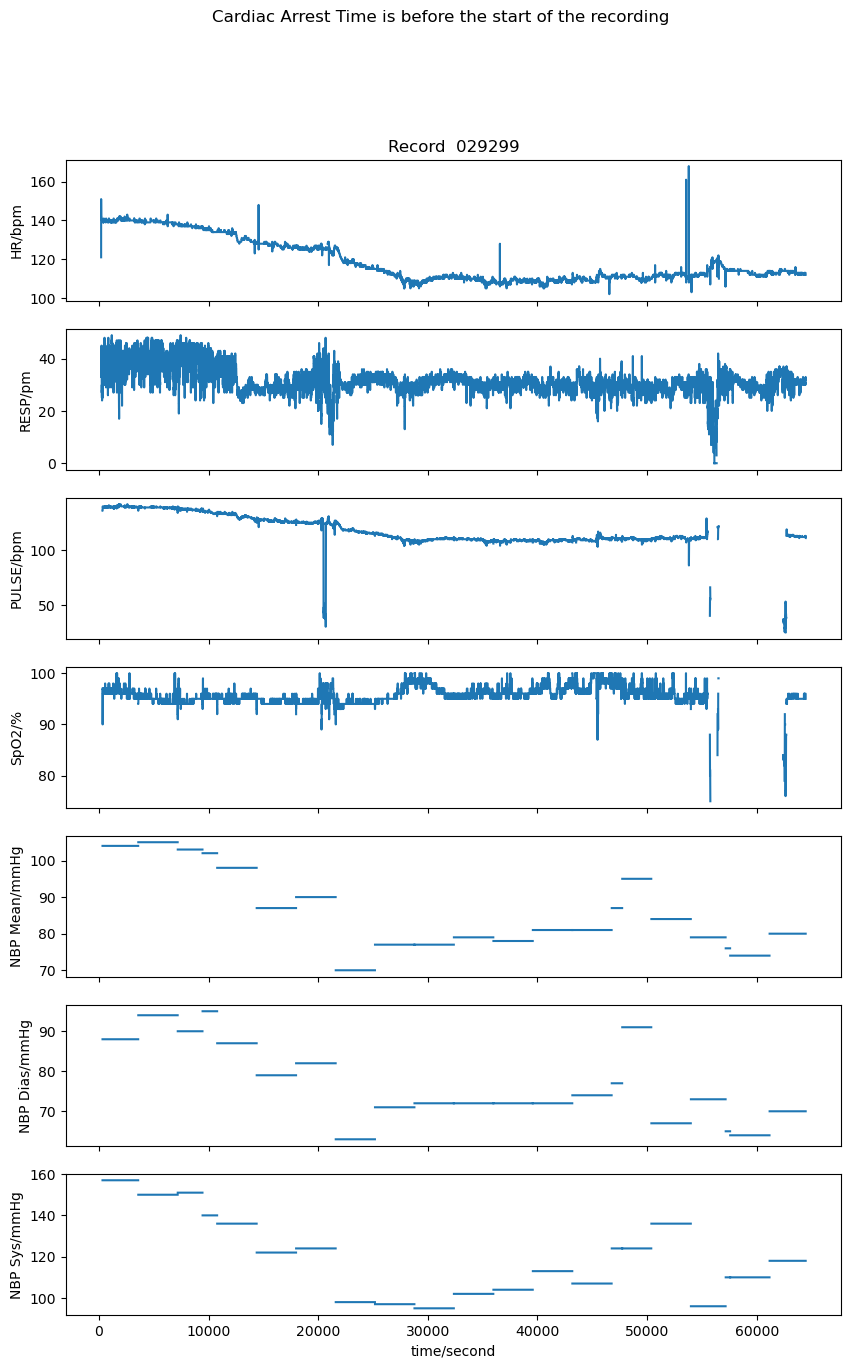

In [50]:
# This is a patient with cardiac arrest
patient_path = get_waveform_path('p029299', 'p029299-2192-12-06-20-01n')

# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2192-11-21 07:38:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_20431/798923300.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p087675-2104-12-05-03-53n',
 'n_sig': 7,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 137280,
 'base_time': datetime.time(3, 53, 10),
 'base_date': datetime.date(2104, 12, 5),
 'comments': ['Location: sicu'],
 'sig_name': ['HR',
  'RESP',
  'PULSE',
  'SpO2',
  'NBP Mean',
  'NBP Dias',
  'NBP Sys'],
 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3591887n.dat',
  '3591887n.dat',
  '3591887n.dat',
  '3591887n.dat',
  '3591887n.dat',
  '3591887n.dat',
  '3591887n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None, None],
 'byte_offse

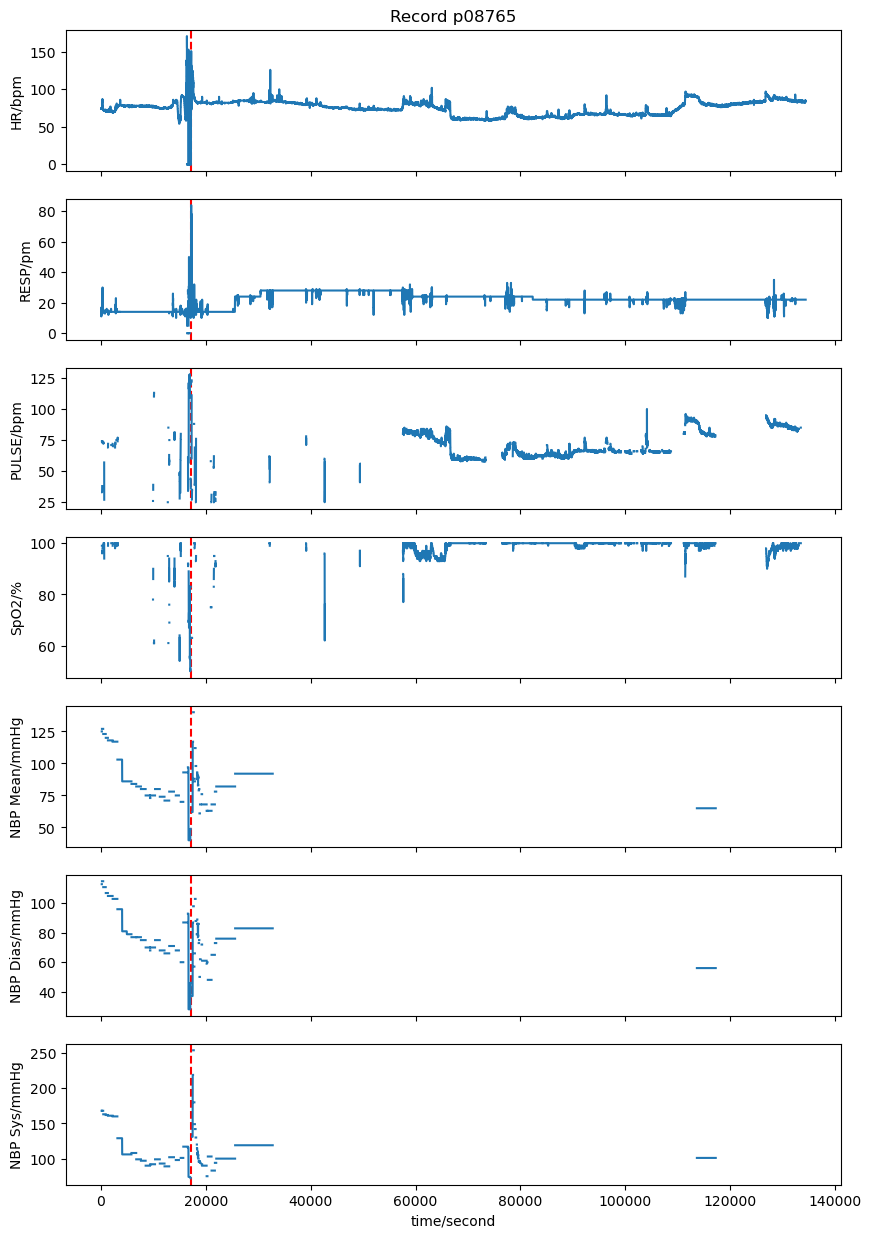

In [54]:
# This is a patient with cardiac arrest
patient_path = get_waveform_path('p087675', 'p087675-2104-12-05-03-53n')
# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record p08765', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2104-12-05 08:40:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_34028/1474199477.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p070723-2163-11-18-16-28n',
 'n_sig': 5,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 158241,
 'base_time': datetime.time(16, 28, 34),
 'base_date': datetime.date(2163, 11, 18),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR', 'RESP', 'PULSE', 'SpO2', 'CVP'],
 'p_signal': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None],
 'byte_offset': [None, None, None, None, None],
 'adc_gain': [1.0, 1.0, 1.0, 1.0, 1.0],
 'baseline': [0, 0, 0, 0, 0],
 'units': ['bpm', 'pm', 'bpm', '%', 'mmHg'],
 'adc_re

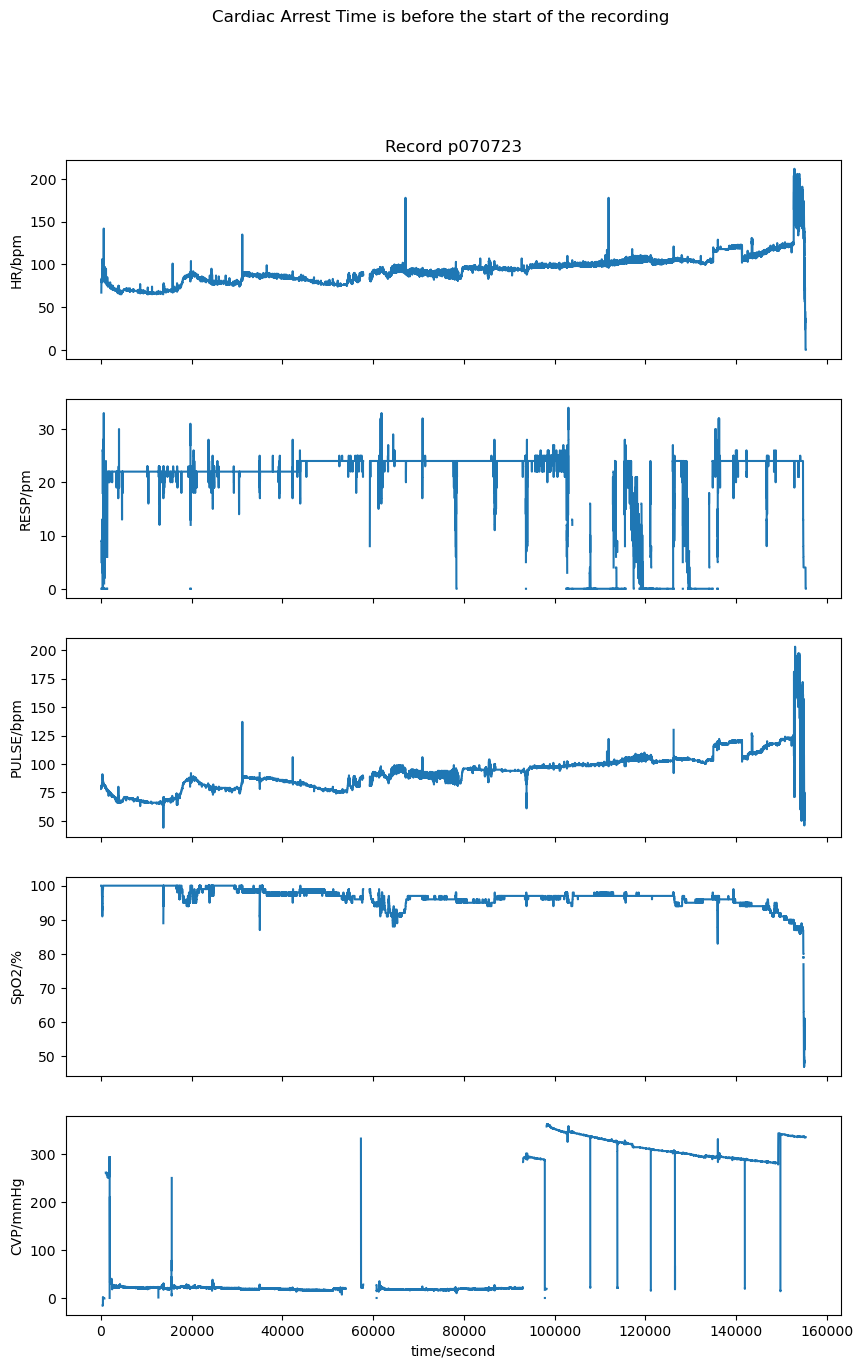

In [60]:

# This is a patient with cardiac arrest
patient_path = get_waveform_path('p070723', 'p070723-2163-11-18-16-28n')
# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record p070723', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2163-11-18 10:40:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

In [73]:

record_df = record.to_dataframe()

# Given a dataframe record_df that has datetimeindex, 
# write code that create numpy arrays with a sliding window of 10 minutes with a stride of 1 minute.
# The output should be a list of numpy arrays, each numpy array is a 10 minute window of the record_df
# The first numpy array should start at the beginning of the record_df
# The last numpy array should end at the end of the record_df
# The length of the list should be the number of 10 minute windows in the record_df
# Write code below:
# Take 5 seconds of every datettimeindex
record_df = record_df.iloc[::5, :]

# Which means that each should have 120 records
record_arr = np.stack([record_df.iloc[i:i+int(600/5), :].values for i in range(0, len(record_df)-int(600/5), int(60/5))])
record_arr

array([[[ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        ...,
        [ 82.,  18.,  82., 100.,   0.],
        [124.,  17.,  82., 100.,   0.],
        [124.,  18.,  82., 100.,   0.]],

       [[ nan,  nan,  79., 100.,  nan],
        [ nan,  nan,  79., 100.,  nan],
        [ nan,  nan,  79., 100.,  nan],
        ...,
        [ 82.,  nan,  82., 100.,   0.],
        [ 82.,   0.,  82., 100.,   0.],
        [ 82.,  nan,  82., 100.,   0.]],

       [[ 79.,   0.,  80., 100.,  nan],
        [ 79.,   0.,  79., 100.,  nan],
        [ 79.,   0.,  79., 100.,  nan],
        ...,
        [ 82.,   0.,  82., 100.,   0.],
        [ 82.,   0.,  82., 100.,   0.],
        [ 82.,   0.,  81., 100.,   0.]],

       ...,

       [[ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        [

In [65]:
record_df

HR  RESP  PULSE  SpO2  CVP
2163-11-18 16:28:34 NaN   NaN    NaN   NaN  NaN
2163-11-18 16:28:39 NaN   NaN    NaN   NaN  NaN
2163-11-18 16:28:44 NaN   NaN    NaN   NaN  NaN
2163-11-18 16:28:49 NaN   NaN    NaN   NaN  NaN
2163-11-18 16:28:54 NaN   NaN    NaN   NaN  NaN
...                  ..   ...    ...   ...  ...
2163-11-20 12:25:34 NaN   NaN    NaN   NaN  NaN
2163-11-20 12:25:39 NaN   NaN    NaN   NaN  NaN
2163-11-20 12:25:44 NaN   NaN    NaN   NaN  NaN
2163-11-20 12:25:49 NaN   NaN    NaN   NaN  NaN
2163-11-20 12:25:54 NaN   NaN    NaN   NaN  NaN

[31649 rows x 5 columns]

In [74]:
record_arr.shape

(2628, 120, 5)

In [75]:
record_arr.reshape(120,5,2628)

array([[[ nan,  nan,  nan, ...,  84.,   0.,  84.],
        [100.,   0.,  84., ..., 100.,  nan,  80.],
        [ 22.,  80., 100., ...,  nan,  80., 100.],
        [ nan,  97.,  nan, ..., 257.,  78.,  nan],
        [ 78., 100., 257., ...,  76., 100., 252.]],

       [[ 76.,  22.,  76., ...,  76.,  22.,  76.],
        [100., 253.,  76., ..., 100.,  31.,  74.],
        [ 22.,  74., 100., ...,  22.,  74., 100.],
        [ nan,  74.,  22., ...,  23.,  72.,  22.],
        [ 72., 100.,  23., ...,  70., 100.,  23.]],

       [[ 70.,  22.,  71., ...,  71.,  22.,  71.],
        [100.,  24.,  71., ..., 100.,  22.,  69.],
        [ 20.,  68., 100., ...,  21.,  68., 100.],
        [ 21.,  69.,  22., ...,  23.,  69.,  22.],
        [ 67., 100.,  24., ...,  67., 100.,  24.]],

       ...,

       [[176.,  24., 183., ..., 154.,  24., 106.],
        [ 88., 336., 152., ...,  88., 336., 162.],
        [ 24.,  88.,  88., ...,  13., 131.,  87.],
        [336., 174.,  13., ..., 335.,  39.,   4.],
        [ na

Reading a waveform
From demo https://github.com/MIT-LCP/wfdb-python/blob/main/demo.ipynb

- Matching waveforms to hospital admissions: I am currently trying to match specific waveforms from the Matched Waveform subset to hospital admission ids (HADM_ID) in the admissions table. Currently, I am iterating through and comparing admission times and discharge times of a subject with the time that the waveform began recording (extracted from the filename). [Source](https://github.com/MIT-LCP/mimic-code/issues/438)

In [15]:
patient_path = get_waveform_path('p000194', 'p000194-2112-05-23-14-34')

record = wfdb.rdrecord(patient_path) 

wfdb.plot_wfdb(record=record, title='Record a103l from PhysioNet Challenge 2015') 
display(record.__dict__)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelscott/bd4h/project/data/waveform/physionet.org/files/mimic3wdb-matched/1.0/p00/p000194/p029299-2192-12-06-20-01n.hea'

In [17]:
record_df = record.to_dataframe()
record_df

II
2112-05-23 14:34:23.221  NaN
2112-05-23 14:34:23.229  NaN
2112-05-23 14:34:23.237  NaN
2112-05-23 14:34:23.245  NaN
2112-05-23 14:34:23.253  NaN
...                      ...
2112-05-24 17:40:05.349  0.0
2112-05-24 17:40:05.357  0.0
2112-05-24 17:40:05.365  0.0
2112-05-24 17:40:05.373  0.0
2112-05-24 17:40:05.381  0.0

[12192771 rows x 1 columns]

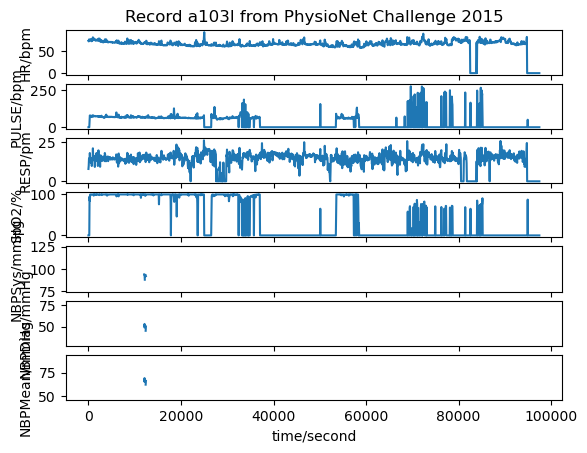

{'record_name': 'p000194-2112-05-23-14-34n',
 'n_sig': 7,
 'fs': 0.0166666666667,
 'counter_freq': 125.0,
 'base_counter': None,
 'sig_len': 1625,
 'base_time': datetime.time(14, 34, 23, 221000),
 'base_date': datetime.date(2112, 5, 23),
 'comments': [],
 'sig_name': ['HR', 'PULSE', 'RESP', 'SpO2', 'NBPSys', 'NBPDias', 'NBPMean'],
 'p_signal': array([[ 73.6,   0. ,   7.9, ...,   nan,   nan,   nan],
        [ 72.3,   0. ,  10. , ..., 120. ,  66. ,  86. ],
        [ 76.8,   0. ,  14.4, ...,   nan,   nan,   nan],
        ...,
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3400942n.dat',
  '3400942n.dat',
  '3400942n.dat',
  '3400942n.dat',
  '3400942n.dat',
  '3400942n.dat',
  '3400942n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 '

In [18]:
patient_path = get_waveform_path('p000194', 'p000194-2112-05-23-14-34n')

record = wfdb.rdrecord(patient_path) 

wfdb.plot_wfdb(record=record, title='Record a103l from PhysioNet Challenge 2015') 
display(record.__dict__)

In [19]:
record.__dict__['p_signal']


array([[ 73.6,   0. ,   7.9, ...,   nan,   nan,   nan],
       [ 72.3,   0. ,  10. , ..., 120. ,  66. ,  86. ],
       [ 76.8,   0. ,  14.4, ...,   nan,   nan,   nan],
       ...,
       [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
       [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
       [  0. ,   0. ,   0. , ...,   nan,   nan,   nan]])

In [20]:
record.fs

0.0166666666667

In [21]:
record.to_dataframe() # Verified that the data is indeed coming in at 0.0166666666667 s apart

HR  PULSE  RESP  SpO2  NBPSys  NBPDias  \
2112-05-23 14:34:23.221000000  73.6    0.0   7.9   0.0     NaN      NaN   
2112-05-23 14:35:23.220999999  72.3    0.0  10.0   0.0   120.0     66.0   
2112-05-23 14:36:23.220999998  76.8    0.0  14.4   0.0     NaN      NaN   
2112-05-23 14:37:23.220999997  74.9    0.0  14.8   0.0     NaN      NaN   
2112-05-23 14:38:23.220999996  75.3   41.6  14.0  94.8     NaN      NaN   
...                             ...    ...   ...   ...     ...      ...   
2112-05-24 17:34:23.220998380   0.0    0.0   0.0   0.0     NaN      NaN   
2112-05-24 17:35:23.220998379   0.0    0.0   0.0   0.0     NaN      NaN   
2112-05-24 17:36:23.220998378   0.0    0.0   0.0   0.0     NaN      NaN   
2112-05-24 17:37:23.220998377   0.0    0.0   0.0   0.0     NaN      NaN   
2112-05-24 17:38:23.220998376   0.0    0.0   0.0   0.0     NaN      NaN   

                               NBPMean  
2112-05-23 14:34:23.221000000      NaN  
2112-05-23 14:35:23.220999999     86.0  
2112-05-23 14:36:23.220999998      NaN  
2112-05-23 14:37:23.220999997      NaN  
2112-05-23 14:38:23.220999996      NaN  
...                                ...  
2112-05-24 17:34:23.220998380      NaN  
2112-05-24 17:35:23.220998379      NaN  
2112-05-24 17:36:23.220998378      NaN  
2112-05-24 17:37:23.220998377      NaN  
2112-05-24 17:38:23.220998376      NaN  

[1625 rows x 7 columns]

<!-- diag_df = pd.read_csv(f'{MIMICPATH}/DIAGNOSES_ICD.csv.gz',compression='gzip') -->

In [22]:
record_df = record.to_dataframe()
record_df
record_df = spark.createDataFrame(record_df.reset_index())

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [23]:
record_df

DataFrame[index: timestamp, HR: double, PULSE: double, RESP: double, SpO2: double, NBPSys: double, NBPDias: double, NBPMean: double]

In [ ]:
record_df = spark.createDataFrame(record_df.reset_index())

In [24]:
record_df

DataFrame[index: timestamp, HR: double, PULSE: double, RESP: double, SpO2: double, NBPSys: double, NBPDias: double, NBPMean: double]

In [25]:
# from pyspark.streaming import StreamingContext
# ssc = StreamingContext(sc, 1)
# inputStream = ssc.socketTextStream("localhost", 9999)

# outputStream = inputStream.flatMap(lambda line: line.split(" "))
# # inputStream = ssc.queueStream([record_df])
# # outputStream = inputStream
# inputStream.pprint()

# ssc.start()